# Chlorophyll A Data Vis Workbook
### Amy Phung, March 2020

### Imports

In [227]:
%matplotlib inline
import scipy
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Globals
Defined here to make code a bit more readable

In [263]:
SAT_CHL_A_NAME = "chlor_a [mg m^-3] @ Dummy=first" 
BGC_CHL_A_NAME = "Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0"
MIXED_LAYER_DEPTH = 200 # meters

### Load & Format BGC Data

In [264]:
bgc_df = pd.read_csv("data/argo-isosurface-data.csv")
bgc_df.dropna(axis=1, how='all', inplace=True) # Remove unused columns
bgc_df.dropna(inplace=True) # Drop points missing chlorophyll values
bgc_df.drop_duplicates(inplace=True) # Drop duplicates (for some reason stations 1-9 like to duplicate)
bgc_df["Station Num"]=range(1,len(bgc_df)+1) # Add in column with station numbers
bgc_df[BGC_CHL_A_NAME]=bgc_df[BGC_CHL_A_NAME]/20. # Normalize chlorophyll data

bgc_df["Overall Day Num"] = bgc_df["Time [yr]"].astype(int) * 365 + bgc_df["Day of Year"] # Add in column with total days
bgc_df.head()

,Cruise,QV:ARGO,Station,QV:ARGO.1,Type,QV:ARGO.2,yyyy-mm-ddThh:mm:ss.sss,QV:ARGO.3,Longitude [degrees_east],QV:ARGO.4,...,QV:ARGO.5,QV:ODV:STATION,Dummy Var,Longitude,Latitude,Time [yr],Day of Year,Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0,Station Num,Overall Day Num
1,5905108,0,1a_D_A_bio,0,C,0,2017-07-29T20:01:50,0,185.24200,0,...,0,1,0,185.242,-32.465,2017.57,210,0.598395,1,736415
3,5905108,0,2a_D_A_bio,0,C,0,2017-08-08T20:37:00,0,185.30000,0,...,0,1,0,185.300,-32.267,2017.60,220,0.628195,2,736425
5,5905108,0,3a_D_A_bio,0,C,0,2017-08-18T19:37:50,0,185.25600,0,...,0,1,0,185.256,-32.298,2017.63,230,0.415292,3,736435
7,5905108,0,4a_D_A_bio,0,C,0,2017-08-28T21:43:20,0,185.32600,0,...,0,1,0,185.326,-32.560,2017.66,240,0.514820,4,736445
9,5905108,0,5a_D_A_bio,0,C,0,2017-09-07T23:10:00,0,185.25101,0,...,0,1,0,185.251,-32.979,2017.68,250,0.363909,5,736455


### Load & Format Satellite Data

In [246]:
sat_data_dir = "data/satellite-data"

In [247]:
# Helper Functions
def loadSatelliteData(sat_data_dir):
    """Wrapper function for loading satellite data
    
    Args:
        sat_data_dir (str): string representing file location of all satellite data
    
    Returns:
        sat_df (DataFrame): pandas dataframe containing clean satellite data with chlA values
    """
    sat_df = pd.DataFrame()
    
    for f in glob.glob('%s/*.txt' % sat_data_dir): # Iterate through files in sat_data_dir
        year, day = parseFilenameDate(f)
        new_df = pd.read_csv(f, delimiter="\t",header=1)
        new_df["Time [yr]"] = int(year) # Add year to dataframe
        new_df["Day of Year"] = int(day) # Add day of year to dataframe
        sat_df = pd.concat([new_df, sat_df])
    
    sat_df.dropna(axis=1, how='all', inplace=True) # Remove unused columns
    sat_df.dropna(inplace=True) # Drop points missing chlorophyll values
    sat_df["Overall Day Num"] = sat_df["Time [yr]"].astype(int) * 365 + sat_df["Day of Year"] # Add in column with total days
    
    return sat_df

def parseFilenameDate(filename):
    """Parses satellite data filename for start date
    
    Args:
        filename (str): string representing filename
        
    Returns:
        year (int): year of data
        day (int): day of year of data
    """
    start_idx = filename.find("\V") + 2 #Each date starts with \V, and add 2 to move cursor over by /V
    year = filename[start_idx:start_idx + 4] #Year is 4 characters long 
    day = filename[start_idx + 4:start_idx + 7] #Day of year is 3 characters long

    return year, day

In [248]:
sat_df = loadSatelliteData(sat_data_dir)

In [249]:
sat_df.head()

,Cruise,QF,Station,QF.1,Type,QF.2,QF.3,Longitude [degrees_east],QF.4,Latitude [degrees_north],QF.5,QV:ODV:STATION,Dummy Var,Longitude,Latitude,Time [yr],Day of Year,chlor_a [mg m^-3] @ Dummy=first,Overall Day Num
9,V20200092020016.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,10,1,B,1,1,182.27083,1,-20.02083,1,1,0,-177.729,-20.0208,2020,9,0.101611,737309
10,V20200092020016.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,11,1,B,1,1,182.52083,1,-20.02083,1,1,0,-177.479,-20.0208,2020,9,0.086797,737309
74,V20200092020016.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,75,1,B,1,1,198.52083,1,-20.02083,1,1,0,-161.479,-20.0208,2020,9,0.018389,737309
76,V20200092020016.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,77,1,B,1,1,199.02083,1,-20.02083,1,1,0,-160.979,-20.0208,2020,9,0.026269,737309
88,V20200092020016.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,89,1,B,1,1,202.02083,1,-20.02083,1,1,0,-157.979,-20.0208,2020,9,0.032189,737309


### Lookup Chl-A values
For each station in the BGC argo dataset, look up the nearest lat/long value within correct time period containing Chl-A data in the satellite dataset. Then create dataset to be plotted

In [250]:
# Helper Functions
def findNearestValue(lat, long, day_num, df):
    """Find satellite chl-A value for point closest to input point
    
    Args:
        lat (float): input latitude
        long (float): input longitude
        day_num (int): Overall day number of input point
        df (DataFrame): Pandas dataframe containing satellite data
    
    Returns:
        chl_A_value (float): chl-A value of nearest satellite data point
        nearest_lat (float): Latitiude of nearest data point
        nearest_long (float): Longitude of nearest data point
    """
    time_df = filterByTime(day_num, df)
    nearest_sat_df = findNearestPoint(lat, long, time_df)
    
    chl_A_value = nearest_sat_df[SAT_CHL_A_NAME]
    nearest_lat = nearest_sat_df["Latitude [degrees_north]"]
    nearest_long = nearest_sat_df["Longitude [degrees_east]"]
    
    if chl_A_value.count() == 0: # Check if no points were found
        return None, None, None
    else:
        return float(chl_A_value), float(nearest_lat), float(nearest_long)
    
def filterByTime(day_num, df):
    """Filter dataframe for only applicable time periods.
    
    Assumes satellite data has a column containing the first day number of 
    the time period it covers. We want to filter for the time period during which 
    the point was taken, so we want to find the closest day number in the dataset that 
    isn't larger than the input day number
    
    Args:
        day_num (int): Overall day number of input point
        df (DataFrame): Pandas dataframe containing satellite data
        
    Returns:
        time_df (DataFrame): Pandas dataframe containing time-filtered satellite data
    """
    # Find last satellite day number that is less than input day number
    closest_day = df["Overall Day Num"][day_num - df["Overall Day Num"] >=0].max()
    # Create bool array with values we want to keep and use it to filter out irrelevant timeframes
    time_df = df[df["Overall Day Num"]==closest_day]
    
    return time_df

def findNearestPoint(lat, long, df):
    """ Finds approximate nearest point - first searches latitude, 
    then searches longitude
    
    Doesn't truly find nearest point because that would be more complicated 
    but unneccessary since I'm assuming the data is rather grid-like
    
    Args:
        lat (float): Latitude of point to find in grid
        long (float): Longitude of point to find in grid
        df (DataFrame): pandas dataframe containing grid of satellite points
        
    Returns:
        nearest_chl_a (DataFrame): pandas dataframe containing nearest valid satellite station
    """
    
    lats = df["Latitude [degrees_north]"]

    nearest_lat_error = abs(lats-lat).min() # Compute error for nearest latitude point
    nearest_lat_idxs = abs(lats-lat) == nearest_lat_error # Create bool array where latitude matches
    lat_sat_df = df[nearest_lat_idxs] # Use bool array to filter for matching latitude

    longs = lat_sat_df["Longitude [degrees_east]"] # Only look at longitude within matching latitude set
    nearest_long_error = abs(longs-long).min()
    nearest_long_idxs = abs(longs-long) == nearest_long_error

    nearest_chl_a = lat_sat_df[nearest_long_idxs]
    
    return nearest_chl_a
#     nearest_pt = lat_sat_df[nearest_long_idxs][SAT_CHL_A_NAME]
    
#     if nearest_pt.count() == 0: # Check if no points were found
#         return None
#     else:
#         return float(nearest_pt)

### Create Compiled Dataset

In [251]:
compiled_dict = {"Station Num": [],
                 "Overall Day Num": [],
                 "BGC Lat": [],
                 "BGC Long": [],
                 "BGC Chl-A": [],
                 "Sat Lat": [],
                 "Sat Long": [],
                 "Sat Chl-A": [],
                } # Initialize empty list for each variable


for i in range(0,len(bgc_df)): # For each station in BGC dataset
    stn = bgc_df.iloc[i] # Get BGC data from station
    
    # Fill in Station Number
    stn_num = stn["Station Num"]
    compiled_dict["Station Num"].append(stn_num)
    
    # Fill in Day Number
    day_num = stn["Overall Day Num"]
    compiled_dict["Overall Day Num"].append(day_num)
    
    # Fill in Latitude
    lat = stn["Latitude [degrees_north]"]
    compiled_dict["BGC Lat"].append(lat)
    
    # Fill in Longitude
    long = stn["Longitude [degrees_east]"]
    compiled_dict["BGC Long"].append(long)
    
    # Fill in BGC Chl-A data
    bgc_chl = stn[BGC_CHL_A_NAME]
    compiled_dict["BGC Chl-A"].append(bgc_chl)
    
    # Compute & fill in Satellite Chl-A data
    sat_chl, sat_lat, sat_long = findNearestValue(lat, long, day_num, sat_df)
    compiled_dict["Sat Lat"].append(sat_lat)
    compiled_dict["Sat Long"].append(sat_long)
    compiled_dict["Sat Chl-A"].append(sat_chl)
               

compiled_df = pd.DataFrame(compiled_dict)
compiled_df.head()

,BGC Chl-A,BGC Lat,BGC Long,Overall Day Num,Sat Chl-A,Sat Lat,Sat Long,Station Num
0,0.598395,-32.465,185.24200,736415,NaN,NaN,NaN,1
1,0.628195,-32.267,185.30000,736425,NaN,NaN,NaN,2
2,0.415292,-32.298,185.25600,736435,0.216514,-32.27083,185.27083,3
3,0.514820,-32.560,185.32600,736445,0.189774,-32.52083,185.27083,4
4,0.363909,-32.979,185.25101,736455,0.184411,-33.02083,185.27083,5


### Plot Data
Objective: Create a plot that quantifies error between different Chl-A sensors

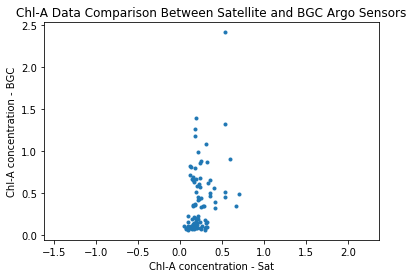

In [252]:
# TODO: Make this object-oriented
compiled_df = compiled_df.dropna() # TODO: make this better
plt.plot(compiled_df["Sat Chl-A"], compiled_df["BGC Chl-A"], '.')

plt.axis("equal")
plt.title("Chl-A Data Comparison Between Satellite and BGC Argo Sensors")
plt.xlabel("Chl-A concentration - Sat")
plt.ylabel("Chl-A concentration - BGC")

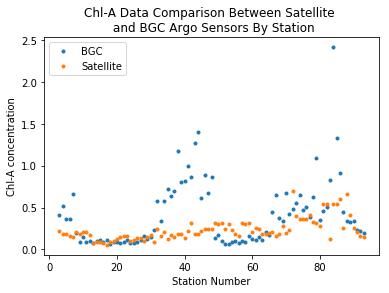

In [253]:
# Comparison by station
# TODO: Make this object-oriented
compiled_df = compiled_df.dropna() # TODO: make this better
plt.plot(compiled_df["Station Num"], compiled_df["BGC Chl-A"], '.')

# TODO: make this prettier 
compile2 = compiled_df.dropna() # Temporary - currently used to filter na values, will be fixed once all data is loaded
plt.plot(compile2["Station Num"], compile2["Sat Chl-A"], '.')
# # compile2
plt.legend(["BGC", "Satellite"])

plt.title("Chl-A Data Comparison Between Satellite \n and BGC Argo Sensors By Station")
plt.xlabel("Station Number")
plt.ylabel("Chl-A concentration")

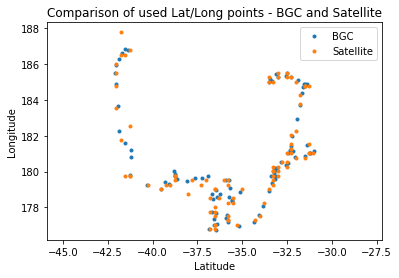

In [254]:
# TODO: Make this object-oriented
plt.plot(compiled_df["BGC Lat"], compiled_df["BGC Long"], '.')
plt.plot(compiled_df["Sat Lat"], compiled_df["Sat Long"], '.')
plt.axis("equal")


plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend(["BGC", "Satellite"])
plt.title("Comparison of used Lat/Long points - BGC and Satellite")

In [255]:
"""
In Wellington

Priority:
Figure out maps in python
Figure out .nc file opening
Get up to date satellite data 

Other:
Offline latex
Images

Papers:
Satellite sampling depth
Satellite resolution/exact sensors used
BGC sensors used
Our sensors
Look at paper to find things that need documentation


Notes:
Challenges? - in our area, lots of different levels of chlorophyll - makes it difficult to pinpoint - using most sensitive range, but it has three levels of sensitivity
Explain integration to 20 with figures

Publish code (put online + link ok)
Should include description of code (how it got there)
Find more literature on sensors to add to intro

Throw in figures - throw in "typical" profiles to verify 20 is valid

Data source should also go in methods

Questions:
hc timestamp - 0020
B and C types in dataset: bottle vs ctd - bottle is snapshot values (subject to noise), ctd is averaged by bin (1m bins) - Bottle depth values currently broken, will be fixed later 
fluor_chl_df - identical timestamps, very different values - because of broken values
Surface data calibration - should I use flow through data instead of hc data?
Chl-a accuracy in papers? difficult to find - ask jan about virs dataset documentation in wellington, reason through fluromoter calibration - fluorometers are only as good as their calibration
Previous cruise track data - getting now on flash drive, in wellington, ask about getting 1m data opposed to hourly

Questions V2:
Using only 20 m depth makes a pretty crappy calibration curve

Figures:
Depth comparison of BGC & us?

Code To-Do:
properly calibrate hydrocast dataset - didn't work too well
import + parse new flow through data - in progress - writing nearest timestamp lookup function
properly calibrate new flow through data
import + parse old cruise data (hourly, hydrocast)
make plot with all cruise tracks
try using old data in calibration?
"""


'\nIn Wellington\n\nPriority:\nFigure out maps in python\nFigure out .nc file opening\nGet up to date satellite data \n\nOther:\nOffline latex\nImages\n\nPapers:\nSatellite sampling depth\nSatellite resolution/exact sensors used\nBGC sensors used\nOur sensors\nLook at paper to find things that need documentation\n\n\nNotes:\nChallenges? - in our area, lots of different levels of chlorophyll - makes it difficult to pinpoint - using most sensitive range, but it has three levels of sensitivity\nExplain integration to 20 with figures\n\nPublish code (put online + link ok)\nShould include description of code (how it got there)\nFind more literature on sensors to add to intro\n\nThrow in figures - throw in "typical" profiles to verify 20 is valid\n\nData source should also go in methods\n\nQuestions:\nhc timestamp - 0020\nB and C types in dataset: bottle vs ctd - bottle is snapshot values (subject to noise), ctd is averaged by bin (1m bins) - Bottle depth values currently broken, will be fix

### S290 Data

In [256]:
# Helper Functions 
   
def computeTotalDays(timestamp):
    """Parses timestamp in format yyyy-mm-ddThh:mm:ss.sss from datasets 
    and returns an overall day number used to easily compare various
    datasets.
    
    Args:
        timestamp (str): Timestamp in the format yyyy-mm-ddThh:mm:ss.sss
        
    Returns:
        day_num (int): Overall day number
    """
    days_in_month = np.array([0,31,28,31,30,31,30,31,31,30,31,30,31])
    total_days = days_in_month.cumsum()
    
    year = int(timestamp[0:4])
    month = int(timestamp[5:7])
    day = int(timestamp[8:10])
    
    day_of_year = year * 365 + total_days[month-1] + day
    return day_of_year

def getStationNum(station_name):
    """Parses station name from hydrocast dataset and returns an int 
    representing station number.
    
    Args:
        station_name (str): Hydrocast station name in the format S290-###-HC
        
    Returns:
        station_num (int): Hydrocast station number
    """
    return int(station_name[5:8])

def correctHCTimestamp(timestamp):
    """Applies correction to HC timestamp - 2020 is incorrectly written as
    0020, so this function returns a new timestamp in the correct format
    
    Args:
        timestamp (str): Incorrect timestamp from hydrocast data
    
    Returns:
        corrected_timestamp (str): Corrected timestamp
    """
    new_timestamp = "2020" + timestamp[4:]
    return new_timestamp
    
# correctHCTimestamp("0020-02-18T01:36")

In [265]:
# To get data, Export>Station Data>ODV Spreadsheet file>Uncheck all exports
hc_df = pd.read_csv("data/data_from_S290-CTD-HC-2.txt", delimiter="\t",header=27)

# Fill in cruise, station, type, date, lat, long, bottom depth with most recent values
col_to_fill = ["Cruise", 
               "Station",
               "Type",
               "yyyy-mm-ddThh:mm:ss.sss",
               "Longitude [degrees_east]",
               "Latitude [degrees_north]",
               "Bot. Depth [m]"]

for col in col_to_fill: hc_df[col].fillna(method="pad", inplace=True)
    
 # Add in column with indices to use
hc_df["Index"] = range(len(hc_df))
# Add in column with station numbers as integers
hc_df["Station Num"] = hc_df["Station"].apply(getStationNum) 
# Add in column with corrected timestamps
hc_df["Corrected Timestamp"] = hc_df["yyyy-mm-ddThh:mm:ss.sss"].apply(correctHCTimestamp)
# Add in overall day numbers
hc_df["Overall Day Num"] = hc_df["Corrected Timestamp"].apply(computeTotalDays)

hc_df

,Cruise,Station,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Depth [m],Temperature [°C],Salinity [psu],"Density [sigma-theta,Kg/m^3]",Chl a Fluorescence [V],"Oxygen,SBE43 [umol/Kg]",PAR Irradience [uE/m2/s],Chl-a [ug/L],pH,Index,Station Num,Corrected Timestamp,Overall Day Num
0,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,1.0,22.4740,35.5891,24.5315,0.16200,217.98700,1150.0,NaN,NaN,0,1,2020-02-18T01:36,737349
1,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,2.0,22.4744,35.5890,24.5314,0.16800,217.63499,816.0,NaN,NaN,1,1,2020-02-18T01:36,737349
2,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,3.0,22.5327,35.5881,24.5141,0.17900,217.65800,679.0,NaN,NaN,2,1,2020-02-18T01:36,737349
3,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,4.0,22.6162,35.5894,24.4913,0.17300,217.75999,555.0,NaN,NaN,3,1,2020-02-18T01:36,737349
4,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,5.0,22.6031,35.5902,24.4957,0.17300,217.80600,511.0,NaN,NaN,4,1,2020-02-18T01:36,737349
5,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,6.0,22.2677,35.5944,24.5944,0.16900,218.22000,465.0,NaN,NaN,5,1,2020-02-18T01:36,737349
6,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,7.0,22.1073,35.5870,24.6341,0.16800,218.47701,425.0,NaN,NaN,6,1,2020-02-18T01:36,737349
7,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,8.0,22.0566,35.5845,24.6466,0.16600,218.44400,373.0,NaN,NaN,7,1,2020-02-18T01:36,737349
8,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,9.0,22.0296,35.5837,24.6536,0.17200,218.42599,328.0,NaN,NaN,8,1,2020-02-18T01:36,737349
9,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,10.0,22.0168,35.5851,24.6583,0.18100,218.55600,335.0,NaN,NaN,9,1,2020-02-18T01:36,737349


In [266]:
"""
For computing best fit line, use top several bottles (mixed layer is no deeper than 20m) - can use calibrated values up until that point

Back of the envelope: 1px = 900m, hourly data would be approx 7px - so let's use 60s average data (raw data) instead of the compiled
Raw data is not really useful - things can't change in a couple of seconds

"""

"\nFor computing best fit line, use top several bottles (mixed layer is no deeper than 20m) - can use calibrated values up until that point\n\nBack of the envelope: 1px = 900m, hourly data would be approx 7px - so let's use 60s average data (raw data) instead of the compiled\nRaw data is not really useful - things can't change in a couple of seconds\n\n"

In [267]:
# Extract Chl-A/Fluorometer data
chl_a_data = hc_df["Chl-a [ug/L]"].dropna()
chl_df = hc_df[hc_df.isin(chl_a_data.index)["Index"]==True] # Dataframe to use for calibration

fluor_data = chl_df["Chl a Fluorescence [V]"].dropna()
fluor_chl_df = chl_df[chl_df.isin(fluor_data.index)["Index"]==True]
# Only use data points from up to mixed layer depth
calibration_df_hc = fluor_chl_df[fluor_chl_df["Depth [m]"] < MIXED_LAYER_DEPTH]
calibration_df_hc.head()

,Cruise,Station,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Depth [m],Temperature [°C],Salinity [psu],"Density [sigma-theta,Kg/m^3]",Chl a Fluorescence [V],"Oxygen,SBE43 [umol/Kg]",PAR Irradience [uE/m2/s],Chl-a [ug/L],pH,Index,Station Num,Corrected Timestamp,Overall Day Num
11007,S290,S290-002-HC,B,0020-02-19T09:12,174.90199,-35.785,128.0,46.0,17.3506,35.4942,25.8113,0.70100,195.79700,NaN,0.214,NaN,11007,2,2020-02-19T09:12,737350
11010,S290,S290-002-HC,B,0020-02-19T09:12,174.90199,-35.785,128.0,75.0,15.5673,35.3885,26.1477,0.10700,179.03799,NaN,0.062,NaN,11010,2,2020-02-19T09:12,737350
11013,S290,S290-002-HC,B,0020-02-19T09:12,174.90199,-35.785,128.0,99.0,14.8271,35.3370,26.2731,0.07400,168.20799,NaN,0.025,NaN,11013,2,2020-02-19T09:12,737350
11018,S290,S290-003-HC,B,0020-02-19T21:43,175.00700,-35.488,280.0,11.0,20.7679,35.6280,25.0358,0.38076,230.69400,NaN,0.196,8.16,11018,3,2020-02-19T21:43,737350
11020,S290,S290-003-HC,B,0020-02-19T21:43,175.00700,-35.488,280.0,37.0,17.8064,35.5039,25.7074,0.50444,214.45599,NaN,0.384,8.10,11020,3,2020-02-19T21:43,737350


<function matplotlib.pyplot.scatter>

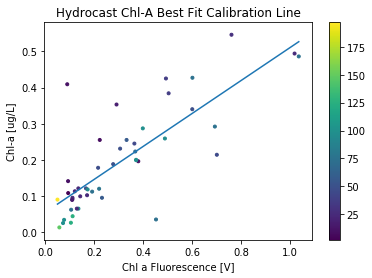

In [272]:
# Get best fit + visualize Chl-A/Fluorometer data
plt.scatter(calibration_df_hc["Chl a Fluorescence [V]"], 
            calibration_df_hc["Chl-a [ug/L]"], 
            c=calibration_df_hc["Depth [m]"],
            marker='.'
            
           )
plt.colorbar()
plt.xlabel("Chl a Fluorescence [V]")
plt.ylabel("Chl-a [ug/L]")
plt.title("Hydrocast Chl-A Best Fit Calibration Line")

# Best fit line
fit_line_coeff = scipy.polyfit(calibration_df_hc["Chl a Fluorescence [V]"], 
                               calibration_df_hc["Chl-a [ug/L]"], 1) # Least squares; 1 is order
fit_line = np.poly1d(fit_line_coeff)
xp = np.linspace(calibration_df_hc["Chl a Fluorescence [V]"].min(),
                 calibration_df_hc["Chl a Fluorescence [V]"].max(),
                 100)
plt.plot(xp, fit_line(xp))

plt.scatter

# TODO: Find best-fit line r value (basically error, measure of "how good" best fit line is)

In [273]:
# Apply best fit line to full dataset
hc_df["Calculated Chl-A"] = hc_df["Chl a Fluorescence [V]"].apply(fit_line)
# hc_df

In [274]:
# Filter for surface data only
hc_depth_df = hc_df[hc_df["Depth [m]"]==1]
surface_hc_df = hc_depth_df[hc_depth_df["Type"]=="C"]
# surface_hc_df

In [275]:
# # TODO: Make this object-oriented
# plt.plot(compiled_df["BGC Lat"], compiled_df["BGC Long"], '.')
# plt.plot(compiled_df["Sat Lat"], compiled_df["Sat Long"], '.')
# plt.plot(surface_hc_df["Latitude [degrees_north]"], 
#          surface_hc_df["Longitude [degrees_east]"], '.')

# plt.axis("equal")
# plt.xlabel("Latitude")
# plt.ylabel("Longitude")

# plt.legend(["BGC", "Satellite", "S290-HC"])
# plt.title("Comparison of used Lat/Long points")

### Create Compiled HC Dataset

In [276]:
compiled_dict = {"Station Num": [],
                 "Overall Day Num": [],
                 "HC Lat": [],
                 "HC Long": [],
                 "HC Chl-A": [],
                 "Sat Lat": [],
                 "Sat Long": [],
                 "Sat Chl-A": [],
                } # Initialize empty list for each variable


for i in range(0,len(surface_hc_df)): # For each station in HC dataset
    stn = surface_hc_df.iloc[i] # Get HC data from station
    
    # Fill in Station Number
    stn_num = stn["Station Num"]
    compiled_dict["Station Num"].append(stn_num)
    
    # Fill in Day Number
    day_num = stn["Overall Day Num"]
    compiled_dict["Overall Day Num"].append(day_num)
    
    # Fill in Latitude
    lat = stn["Latitude [degrees_north]"]
    compiled_dict["HC Lat"].append(lat)
    
    # Fill in Longitude
    long = stn["Longitude [degrees_east]"]
    compiled_dict["HC Long"].append(long)
    
    # Fill in HC Chl-A data
    hc_chl = stn["Calculated Chl-A"]
    compiled_dict["HC Chl-A"].append(hc_chl)
    
    # Compute & fill in Satellite Chl-A data
    sat_chl, sat_lat, sat_long = findNearestValue(lat, long, day_num, sat_df)
    compiled_dict["Sat Lat"].append(sat_lat)
    compiled_dict["Sat Long"].append(sat_long)
    compiled_dict["Sat Chl-A"].append(sat_chl)
               

hc_compiled_df = pd.DataFrame(compiled_dict)
hc_compiled_df.head()

,HC Chl-A,HC Lat,HC Long,Overall Day Num,Sat Chl-A,Sat Lat,Sat Long,Station Num
0,0.128090,-36.357,175.17200,737349,0.737986,-36.27083,175.27084,1
1,0.180602,-35.786,174.90199,737350,0.459683,-35.77083,175.02084,2
2,0.163250,-35.488,175.00700,737350,0.350384,-35.52083,175.02084,3
3,0.126720,-35.337,174.83200,737351,0.343864,-35.27083,174.77084,4
4,0.111651,-34.976,174.61400,737351,0.151937,-35.02083,174.52084,5


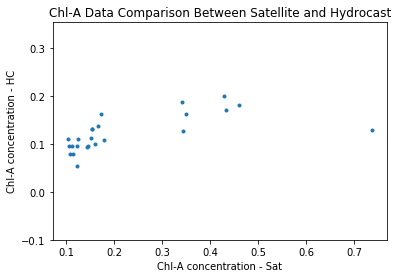

In [277]:
# TODO: Make this object-oriented
plt.axis("equal")
# plt.xlim([0,0.4])
# plt.ylim([0,0.4])
plt.plot(hc_compiled_df["Sat Chl-A"], hc_compiled_df["HC Chl-A"], '.')


plt.title("Chl-A Data Comparison Between Satellite and Hydrocast")
plt.xlabel("Chl-A concentration - Sat")
plt.ylabel("Chl-A concentration - HC")


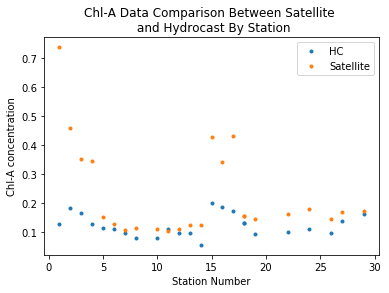

In [278]:
# Comparison by station
plt.plot(hc_compiled_df["Station Num"], hc_compiled_df["HC Chl-A"], '.')
plt.plot(hc_compiled_df["Station Num"], hc_compiled_df["Sat Chl-A"], '.')

plt.legend(["HC", "Satellite"])

plt.title("Chl-A Data Comparison Between Satellite \n and Hydrocast By Station")
plt.xlabel("Station Number")
plt.ylabel("Chl-A concentration")

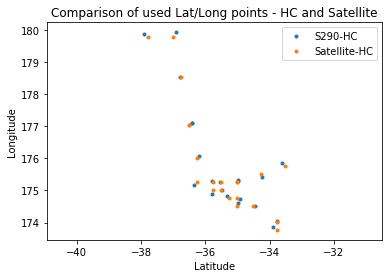

In [124]:
# TODO: Make this object-oriented
plt.plot(hc_compiled_df["HC Lat"], hc_compiled_df["HC Long"], '.')
plt.plot(hc_compiled_df["Sat Lat"], hc_compiled_df["Sat Long"], '.')

plt.axis("equal")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.legend(["S290-HC", "Satellite-HC"])
plt.title("Comparison of used Lat/Long points - HC and Satellite")

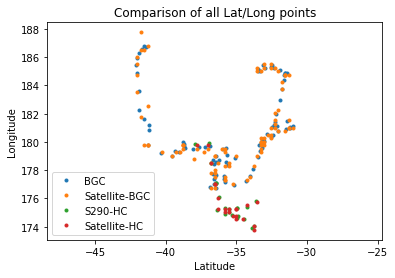

In [125]:
# TODO: Make this object-oriented
plt.plot(compiled_df["BGC Lat"], compiled_df["BGC Long"], '.')
plt.plot(compiled_df["Sat Lat"], compiled_df["Sat Long"], '.')
plt.plot(hc_compiled_df["HC Lat"], hc_compiled_df["HC Long"], '.')
plt.plot(hc_compiled_df["Sat Lat"], hc_compiled_df["Sat Long"], '.')

plt.axis("equal")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.legend(["BGC", "Satellite-BGC", "S290-HC", "Satellite-HC"])
plt.title("Comparison of all Lat/Long points")

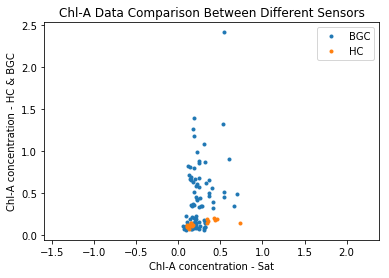

In [126]:
# TODO: Make this object-oriented
plt.axis("equal")

plt.plot(compiled_df["Sat Chl-A"], compiled_df["BGC Chl-A"], '.')
plt.plot(hc_compiled_df["Sat Chl-A"], hc_compiled_df["HC Chl-A"], '.')

plt.axis("equal")
plt.title("Chl-A Data Comparison Between Different Sensors")
plt.xlabel("Chl-A concentration - Sat")
plt.ylabel("Chl-A concentration - HC & BGC")
plt.legend(["BGC", "HC"])

# # TODO: Make this object-oriented
# compiled_df = compiled_df.dropna() # TODO: make this better
# plt.plot(compiled_df["Sat Chl-A"], compiled_df["BGC Chl-A"], '.')


### Flow-through (old)

In [127]:
hourly_df = pd.read_csv("data/S290_Hourlywork_isosurface_data.txt", delimiter="\t",header=1)

In [128]:
hourly_df.dropna(inplace=True)
# Add in column with indices to use
hourly_df["Index"] = range(len(hourly_df))
# hourly_df

In [159]:
# Helper functions
def computeTotalHours(timestamp):
    """Computes the total hours to use as a basis for comparison
    
    Args:
        timestamp (str): timestamp in format yyyy-mm-ddThh:mm:ss.sss
        
    Returns:
        total_hrs (int): total number of hours elapsed
    """
    hour   = int(timestamp[11:13])
    minute = float(timestamp[14:])
    
    total_days = computeTotalDays(timestamp)
    total_hrs = int(round(total_days*24 + hour + minute/60))
    
    return total_hrs
    
def findNearestTime(timestamp, df, col="yyyy-mm-ddThh:mm:ss.sss"):
    """Finds the index nearest timestamp in the specified df.
    Dates are assumed to be in the format yyyy-mm-ddThh:mm:ss.sss
    
    Args:
        timestamp (str): timestamp to find in dataframe
        df (DataFrame): pandas dataframe containing data to be searched through
        col (str): Column to use for the timestamp
        
    Returns:
        nearest_idx (int): Index of dataframe that has the closest timestamp
    """
    
    hours_total_df = df[col].apply(computeTotalHours)
    differences = abs(hours_total_df - computeTotalHours(timestamp))
    min_difference = differences.min()
    print("Diff: " + str(min_difference))
    nearest_idx = int(df[differences==min_difference]["Index"].iloc[0]) # If two are equally close, pick first value
    return nearest_idx
    
# computeTotalHours("2020-02-19T21:43")
findNearestTime("2020-02-19T21:43", hourly_df)

Diff: 0


55

In [160]:
# Create calibration dataset
nearest_hourly_idxs = []

for i in range(0,len(fluor_chl_df)): # For each station in calibration dataset
    stn = fluor_chl_df.iloc[i] # Get data from station
#     print(stn)
    time = stn["Corrected Timestamp"]
    print(time)
    nearest_idx = findNearestTime(time, hourly_df)
    nearest_hourly_idxs.append(nearest_idx)
    
nearest_hourly_idxs

2020-02-19T09:12
Diff: 1
2020-02-19T09:12
Diff: 1
2020-02-19T09:12
Diff: 1
2020-02-19T21:43
Diff: 0
2020-02-19T21:43
Diff: 0
2020-02-19T21:43
Diff: 0
2020-02-19T21:43
Diff: 0
2020-02-20T09:58
Diff: 0
2020-02-20T09:58
Diff: 0
2020-02-20T09:58
Diff: 0
2020-02-20T09:58
Diff: 0
2020-02-20T09:58
Diff: 0
2020-02-20T21:42
Diff: 2
2020-02-20T21:42
Diff: 2
2020-02-20T21:42
Diff: 2
2020-02-23T21:55
Diff: 0
2020-02-23T21:55
Diff: 0
2020-02-23T21:55
Diff: 0
2020-02-23T21:55
Diff: 0
2020-02-23T21:55
Diff: 0
2020-02-24T09:43
Diff: 0
2020-02-24T09:43
Diff: 0
2020-02-24T09:43
Diff: 0
2020-02-25T09:40
Diff: 0
2020-02-25T09:40
Diff: 0
2020-02-25T09:40
Diff: 0
2020-02-26T09:57
Diff: 18
2020-02-26T09:57
Diff: 18
2020-02-26T09:57
Diff: 18
2020-02-26T09:57
Diff: 18
2020-02-26T09:57
Diff: 18
2020-02-26T22:16
Diff: 30
2020-02-26T22:16
Diff: 30
2020-02-26T22:16
Diff: 30
2020-02-26T22:16
Diff: 30
2020-02-27T09:42
Diff: 42
2020-02-27T09:42
Diff: 42
2020-02-27T09:42
Diff: 42
2020-02-27T09:42
Diff: 42
2020-02-27T2

[44,
 44,
 44,
 55,
 55,
 55,
 55,
 67,
 67,
 67,
 67,
 67,
 77,
 77,
 77,
 97,
 97,
 97,
 97,
 97,
 108,
 108,
 108,
 132,
 132,
 132,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138,
 138]

In [131]:
"""
for station in hc dataset (fluor dataset where depth is 1, calibrated values)


find_nearest_date
    retun index

Result: list of indices, size 1:1 to fluor dataset to use for calibration

"""

'\nfor station in hc dataset (fluor dataset where depth is 1, calibrated values)\n\n\nfind_nearest_date\n    retun index\n\nResult: list of indices, size 1:1 to fluor dataset to use for calibration\n\n'

In [132]:
a = pd.Series([True, True, False])
a.

SyntaxError: invalid syntax (<ipython-input-132-4339d20ae27f>, line 2)

In [ ]:
round(12.69)

In [ ]:
""" 
Hourly data from previous cruise tracks
Our 1min binned flow through data"""

### Flow-through 1-minute Dataset

In [305]:
ft_df = pd.read_csv("data/Event60sec_003.elg", delimiter=",",header=0)
# Remove unnecessary columns
ft_df.dropna(axis=1, inplace=True) 
# Add in column with indices to use
ft_df["Index"] = range(len(ft_df))
ft_df

,Date,Time,GPS-nav-time,GPS-nav-Lat,GPS-nav-Lon,GPS-nav-SOG,GPS-nav-COG,GPS-lab-time,GPS-lab-Lat,GPS-lab-Lon,...,Seatex-MRU-Roll,Seatex-MRU-Pitch,Fluor-CDOM-avg-1-mins-Value,Fluor-CDOM-avg-60-mins-Value,LCI90-payout,LCI90-Spd,LCI90-tension,Xmiss-NewDigital-1-min-Value,Xmiss-NewDigital-avg-60-min-Value,Index
0,02/16/2020,20:03:55,200403,3650.1777S,17446.9062E,6.4,78.8,200403,3650.1769S,17446.9143E,...,2.36,2.33,129.14,129.14,0.0,0.0,25.4563,1521.73,1521.73,0
1,02/16/2020,20:04:55,200503,3650.1931S,17447.0322E,6.1,79.6,200503,3650.1913S,17447.0391E,...,2.61,1.60,129.83,129.83,0.0,0.0,28.7531,1737.70,1737.70,1
2,02/16/2020,20:05:55,200603,3650.2074S,17447.1578E,6.1,79.5,200603,3650.2052S,17447.1666E,...,2.64,1.42,128.73,128.73,0.0,0.0,25.5675,2096.27,2096.27,2
3,02/16/2020,20:06:55,200703,3650.2218S,17447.2817E,6.0,81.0,200703,3650.2227S,17447.2897E,...,2.43,1.33,129.23,129.27,0.0,0.0,27.2659,1832.00,1832.00,3
4,02/16/2020,20:07:55,200803,3650.2423S,17447.4067E,6.1,81.2,200803,3650.2421S,17447.4153E,...,2.18,1.47,129.73,129.67,0.0,0.0,32.1057,1670.03,1670.03,4
5,02/16/2020,20:08:55,200903,3650.2638S,17447.5313E,6.1,82.1,200903,3650.2644S,17447.5387E,...,2.43,1.45,129.30,129.47,0.0,0.0,34.7809,1497.53,1495.70,5
6,02/16/2020,20:09:55,201003,3650.2834S,17447.6560E,6.1,81.4,201003,3650.2856S,17447.6660E,...,2.30,1.39,129.07,128.97,0.0,0.0,16.8322,1257.03,1257.03,6
7,02/16/2020,20:10:55,201103,3650.3028S,17447.7808E,6.1,81.2,201103,3650.3031S,17447.7881E,...,2.26,1.29,130.37,130.37,0.0,0.0,29.7416,999.53,973.37,7
8,02/16/2020,20:11:55,201203,3650.3200S,17447.9072E,6.1,79.0,201203,3650.3183S,17447.9181E,...,2.90,1.12,129.93,129.83,0.0,0.0,33.0050,2019.57,2019.57,8
9,02/16/2020,20:12:55,201303,3650.3279S,17448.0350E,6.2,75.8,201303,3650.3263S,17448.0434E,...,2.36,2.17,130.40,130.43,0.0,0.0,40.4411,2042.57,2042.57,9


In [313]:
# Helper functions
def computeDegreesDecimalFT(gps_val):
    """Converts latitude or longitude value from flow-through dataset
    into a compatible numerical value. 
    Example input values:
        3650.1777S = 36 degrees, 50.1777 minutes South
        4136.8718S = 41 degrees, 36.8718 minutes South
        17446.9143E = 174 degrees, 46.9143 minutes East
        17959.6199W = 179 degrees, 59.6199 minutes West
    
    Args:
        gps_val (str): Input latitude or longitude value to be converted
        
    Output:
        gps_num (float): GPS input value in decimal form
    """
    dec_idx = gps_val.find(".") 
    degrees = int(gps_val[:dec_idx-2]) # Degrees
    minutes = float(gps_val[dec_idx-2:dec_idx+4]) # Minutes
    decimal = minutes/60.
    
    gps_num = degrees + decimal
    
    if gps_val[-1] == "S" or gps_val[-1] == "W":
        gps_num = gps_num*-1
        
    return gps_num

def computeTotalHoursFT(df_row):
    """Computes the total hours to use as a basis for comparison from 
    flow-through dataset
    
    Args:
        df_row (DataFrame): row of flow-through dataset
        
    Returns:
        total_hrs (float): total number of hours elapsed
    """
    date = df_row["Date"]
    time = df_row["Time"]
    
    days_in_month = np.array([0,31,28,31,30,31,30,31,31,30,31,30,31])
    total_days = days_in_month.cumsum()
    
    year   = int(date[6:10])
    month  = int(date[0:2])
    day    = int(date[3:5])
    hour   = int(time[0:2])
    minute = float(time[3:].replace(':','.'))
    
    total_days = year * 365 + total_days[month-1] + day
    total_hrs = total_days * 24 + hour + minute/60.

#     print(year, month, day, hour, minute)
#     print(total_hrs)
       
    return total_hrs
    
def findNearestTime(timestamp, df, col="yyyy-mm-ddThh:mm:ss.sss"):
    """Finds the index nearest timestamp in the specified df.
    Dates are assumed to be in the format yyyy-mm-ddThh:mm:ss.sss
    
    Args:
        timestamp (str): timestamp to find in dataframe
        df (DataFrame): pandas dataframe containing data to be searched through
        col (str): Column to use for the timestamp
        
    Returns:
        nearest_idx (int): Index of dataframe that has the closest timestamp
    """
    
    hours_total_df = df[col].apply(computeTotalHours)
    differences = abs(hours_total_df - computeTotalHours(timestamp))
    min_difference = differences.min()
    print("Diff: " + str(min_difference))
    nearest_idx = int(df[differences==min_difference]["Index"].iloc[0]) # If two are equally close, pick first value
    return nearest_idx
    
# computeTotalHours("2020-02-19T21:43")
findNearestTime("2020-02-19T21:43", hourly_df)
ft_df.apply(computeTotalHoursFT, axis=1)

Diff: 0
2020 2 16 20 3.55
17696348.0592
2020 2 16 20 4.55
17696348.0758
2020 2 16 20 5.55
17696348.0925
2020 2 16 20 6.55
17696348.1092
2020 2 16 20 7.55
17696348.1258
2020 2 16 20 8.55
17696348.1425
2020 2 16 20 9.55
17696348.1592
2020 2 16 20 10.55
17696348.1758
2020 2 16 20 11.55
17696348.1925
2020 2 16 20 12.55
17696348.2092
2020 2 16 20 13.55
17696348.2258
2020 2 16 20 14.55
17696348.2425
2020 2 16 20 15.55
17696348.2592
2020 2 16 20 16.55
17696348.2758
2020 2 16 20 17.55
17696348.2925
2020 2 16 20 18.55
17696348.3092
2020 2 16 20 19.55
17696348.3258
2020 2 16 20 20.55
17696348.3425
2020 2 16 20 21.55
17696348.3592
2020 2 16 20 22.55
17696348.3758
2020 2 16 20 23.55
17696348.3925
2020 2 16 20 24.55
17696348.4092
2020 2 16 20 25.55
17696348.4258
2020 2 16 20 26.55
17696348.4425
2020 2 16 20 27.55
17696348.4592
2020 2 16 20 28.55
17696348.4758
2020 2 16 20 29.55
17696348.4925
2020 2 16 20 30.55
17696348.5092
2020 2 16 20 31.55
17696348.5258
2020 2 16 20 32.55
17696348.5425
2020 2 16

17696355.119
2020 2 17 3 8.14
17696355.1357
2020 2 17 3 9.14
17696355.1523
2020 2 17 3 10.15
17696355.1692
2020 2 17 3 11.15
17696355.1858
2020 2 17 3 12.15
17696355.2025
2020 2 17 3 13.15
17696355.2192
2020 2 17 3 14.15
17696355.2358
2020 2 17 3 15.15
17696355.2525
2020 2 17 3 16.17
17696355.2695
2020 2 17 3 17.17
17696355.2862
2020 2 17 3 18.18
17696355.303
2020 2 17 3 19.18
17696355.3197
2020 2 17 3 20.18
17696355.3363
2020 2 17 3 21.18
17696355.353
2020 2 17 3 22.19
17696355.3698
2020 2 17 3 23.19
17696355.3865
2020 2 17 3 24.21
17696355.4035
2020 2 17 3 25.21
17696355.4202
2020 2 17 3 26.21
17696355.4368
2020 2 17 3 27.21
17696355.4535
2020 2 17 3 28.21
17696355.4702
2020 2 17 3 29.21
17696355.4868
2020 2 17 3 30.21
17696355.5035
2020 2 17 3 31.21
17696355.5202
2020 2 17 3 32.22
17696355.537
2020 2 17 3 33.22
17696355.5537
2020 2 17 3 34.22
17696355.5703
2020 2 17 3 35.22
17696355.587
2020 2 17 3 36.22
17696355.6037
2020 2 17 3 37.22
17696355.6203
2020 2 17 3 38.22
17696355.637
20

2020 2 17 9 11.33
17696361.1888
2020 2 17 9 12.33
17696361.2055
2020 2 17 9 13.34
17696361.2223
2020 2 17 9 14.34
17696361.239
2020 2 17 9 15.34
17696361.2557
2020 2 17 9 16.34
17696361.2723
2020 2 17 9 17.34
17696361.289
2020 2 17 9 18.34
17696361.3057
2020 2 17 9 19.34
17696361.3223
2020 2 17 9 20.34
17696361.339
2020 2 17 9 21.35
17696361.3558
2020 2 17 9 22.37
17696361.3728
2020 2 17 9 23.41
17696361.3902
2020 2 17 9 24.41
17696361.4068
2020 2 17 9 25.41
17696361.4235
2020 2 17 9 26.41
17696361.4402
2020 2 17 9 27.41
17696361.4568
2020 2 17 9 28.41
17696361.4735
2020 2 17 9 29.41
17696361.4902
2020 2 17 9 30.41
17696361.5068
2020 2 17 9 31.42
17696361.5237
2020 2 17 9 32.42
17696361.5403
2020 2 17 9 33.42
17696361.557
2020 2 17 9 34.42
17696361.5737
2020 2 17 9 35.42
17696361.5903
2020 2 17 9 36.42
17696361.607
2020 2 17 9 37.42
17696361.6237
2020 2 17 9 38.42
17696361.6403
2020 2 17 9 39.42
17696361.657
2020 2 17 9 40.42
17696361.6737
2020 2 17 9 41.42
17696361.6903
2020 2 17 9 42

17696366.2233
2020 2 17 14 14.4
17696366.24
2020 2 17 14 15.42
17696366.257
2020 2 17 14 16.46
17696366.2743
2020 2 17 14 17.46
17696366.291
2020 2 17 14 18.46
17696366.3077
2020 2 17 14 19.46
17696366.3243
2020 2 17 14 20.46
17696366.341
2020 2 17 14 21.46
17696366.3577
2020 2 17 14 22.47
17696366.3745
2020 2 17 14 23.47
17696366.3912
2020 2 17 14 24.48
17696366.408
2020 2 17 14 25.48
17696366.4247
2020 2 17 14 26.48
17696366.4413
2020 2 17 14 27.48
17696366.458
2020 2 17 14 28.49
17696366.4748
2020 2 17 14 29.49
17696366.4915
2020 2 17 14 30.49
17696366.5082
2020 2 17 14 31.49
17696366.5248
2020 2 17 14 32.49
17696366.5415
2020 2 17 14 33.49
17696366.5582
2020 2 17 14 34.49
17696366.5748
2020 2 17 14 35.49
17696366.5915
2020 2 17 14 36.49
17696366.6082
2020 2 17 14 37.5
17696366.625
2020 2 17 14 38.5
17696366.6417
2020 2 17 14 39.5
17696366.6583
2020 2 17 14 40.5
17696366.675
2020 2 17 14 41.53
17696366.6922
2020 2 17 14 42.54
17696366.709
2020 2 17 14 43.54
17696366.7257
2020 2 17 1

2020 2 17 20 51.18
17696372.853
2020 2 17 20 52.18
17696372.8697
2020 2 17 20 53.21
17696372.8868
2020 2 17 20 54.21
17696372.9035
2020 2 17 20 55.22
17696372.9203
2020 2 17 20 56.22
17696372.937
2020 2 17 20 57.22
17696372.9537
2020 2 17 20 58.22
17696372.9703
2020 2 17 20 59.22
17696372.987
2020 2 17 21 0.22
17696373.0037
2020 2 17 21 1.23
17696373.0205
2020 2 17 21 2.23
17696373.0372
2020 2 17 21 3.25
17696373.0542
2020 2 17 21 4.28
17696373.0713
2020 2 17 21 5.28
17696373.088
2020 2 17 21 6.28
17696373.1047
2020 2 17 21 7.29
17696373.1215
2020 2 17 21 8.29
17696373.1382
2020 2 17 21 9.29
17696373.1548
2020 2 17 21 10.29
17696373.1715
2020 2 17 21 11.31
17696373.1885
2020 2 17 21 12.35
17696373.2058
2020 2 17 21 13.35
17696373.2225
2020 2 17 21 14.36
17696373.2393
2020 2 17 21 15.36
17696373.256
2020 2 17 21 16.36
17696373.2727
2020 2 17 21 17.36
17696373.2893
2020 2 17 21 18.37
17696373.3062
2020 2 17 21 19.38
17696373.323
2020 2 17 21 20.38
17696373.3397
2020 2 17 21 21.38
1769637

2020 2 18 6 48.51
17696382.8085
2020 2 18 6 49.51
17696382.8252
2020 2 18 6 50.52
17696382.842
2020 2 18 6 51.52
17696382.8587
2020 2 18 6 52.52
17696382.8753
2020 2 18 6 53.53
17696382.8922
2020 2 18 6 54.53
17696382.9088
2020 2 18 6 55.53
17696382.9255
2020 2 18 6 56.53
17696382.9422
2020 2 18 6 57.53
17696382.9588
2020 2 18 6 58.53
17696382.9755
2020 2 18 6 59.54
17696382.9923
2020 2 18 7 0.55
17696383.0092
2020 2 18 7 1.55
17696383.0258
2020 2 18 7 2.55
17696383.0425
2020 2 18 7 3.55
17696383.0592
2020 2 18 7 4.55
17696383.0758
2020 2 18 7 6.01
17696383.1002
2020 2 18 7 7.02
17696383.117
2020 2 18 7 8.02
17696383.1337
2020 2 18 7 9.02
17696383.1503
2020 2 18 7 10.02
17696383.167
2020 2 18 7 11.03
17696383.1838
2020 2 18 7 12.03
17696383.2005
2020 2 18 7 13.03
17696383.2172
2020 2 18 7 14.03
17696383.2338
2020 2 18 7 15.07
17696383.2512
2020 2 18 7 16.07
17696383.2678
2020 2 18 7 17.07
17696383.2845
2020 2 18 7 18.07
17696383.3012
2020 2 18 7 19.07
17696383.3178
2020 2 18 7 20.08
17

2020 2 18 11 56.14
17696387.9357
2020 2 18 11 57.14
17696387.9523
2020 2 18 11 58.14
17696387.969
2020 2 18 11 59.14
17696387.9857
2020 2 18 12 0.14
17696388.0023
2020 2 18 12 1.14
17696388.019
2020 2 18 12 2.15
17696388.0358
2020 2 18 12 3.21
17696388.0535
2020 2 18 12 4.21
17696388.0702
2020 2 18 12 5.21
17696388.0868
2020 2 18 12 6.21
17696388.1035
2020 2 18 12 7.21
17696388.1202
2020 2 18 12 8.21
17696388.1368
2020 2 18 12 9.21
17696388.1535
2020 2 18 12 10.23
17696388.1705
2020 2 18 12 11.24
17696388.1873
2020 2 18 12 12.24
17696388.204
2020 2 18 12 13.24
17696388.2207
2020 2 18 12 14.26
17696388.2377
2020 2 18 12 15.27
17696388.2545
2020 2 18 12 16.27
17696388.2712
2020 2 18 12 17.27
17696388.2878
2020 2 18 12 18.27
17696388.3045
2020 2 18 12 19.27
17696388.3212
2020 2 18 12 20.32
17696388.3387
2020 2 18 12 21.32
17696388.3553
2020 2 18 12 22.32
17696388.372
2020 2 18 12 23.32
17696388.3887
2020 2 18 12 24.32
17696388.4053
2020 2 18 12 25.32
17696388.422
2020 2 18 12 26.34
176963

2020 2 18 17 36.03
17696393.6005
2020 2 18 17 37.03
17696393.6172
2020 2 18 17 38.03
17696393.6338
2020 2 18 17 39.03
17696393.6505
2020 2 18 17 40.03
17696393.6672
2020 2 18 17 41.03
17696393.6838
2020 2 18 17 42.03
17696393.7005
2020 2 18 17 43.03
17696393.7172
2020 2 18 17 44.03
17696393.7338
2020 2 18 17 45.05
17696393.7508
2020 2 18 17 46.05
17696393.7675
2020 2 18 17 47.05
17696393.7842
2020 2 18 17 48.05
17696393.8008
2020 2 18 17 49.05
17696393.8175
2020 2 18 17 50.05
17696393.8342
2020 2 18 17 51.05
17696393.8508
2020 2 18 17 52.05
17696393.8675
2020 2 18 17 53.05
17696393.8842
2020 2 18 17 54.05
17696393.9008
2020 2 18 17 55.05
17696393.9175
2020 2 18 17 56.05
17696393.9342
2020 2 18 17 57.05
17696393.9508
2020 2 18 17 58.05
17696393.9675
2020 2 18 17 59.05
17696393.9842
2020 2 18 18 0.07
17696394.0012
2020 2 18 18 1.07
17696394.0178
2020 2 18 18 2.07
17696394.0345
2020 2 18 18 3.08
17696394.0513
2020 2 18 18 4.08
17696394.068
2020 2 18 18 5.08
17696394.0847
2020 2 18 18 6.08

2020 2 18 23 45.35
17696399.7558
2020 2 18 23 46.35
17696399.7725
2020 2 18 23 47.35
17696399.7892
2020 2 18 23 48.35
17696399.8058
2020 2 18 23 49.35
17696399.8225
2020 2 18 23 50.35
17696399.8392
2020 2 18 23 51.35
17696399.8558
2020 2 18 23 52.35
17696399.8725
2020 2 18 23 53.35
17696399.8892
2020 2 18 23 54.35
17696399.9058
2020 2 18 23 55.35
17696399.9225
2020 2 18 23 56.35
17696399.9392
2020 2 18 23 57.35
17696399.9558
2020 2 18 23 58.35
17696399.9725
2020 2 18 23 59.35
17696399.9892
2020 2 19 0 0.36
17696400.006
2020 2 19 0 1.38
17696400.023
2020 2 19 0 2.38
17696400.0397
2020 2 19 0 3.38
17696400.0563
2020 2 19 0 4.38
17696400.073
2020 2 19 0 5.38
17696400.0897
2020 2 19 0 6.38
17696400.1063
2020 2 19 0 7.39
17696400.1232
2020 2 19 0 8.39
17696400.1398
2020 2 19 0 9.39
17696400.1565
2020 2 19 0 10.39
17696400.1732
2020 2 19 0 11.39
17696400.1898
2020 2 19 0 12.39
17696400.2065
2020 2 19 0 13.4
17696400.2233
2020 2 19 0 14.4
17696400.24
2020 2 19 0 15.4
17696400.2567
2020 2 19 0

2020 2 19 5 23.46
17696405.391
2020 2 19 5 24.46
17696405.4077
2020 2 19 5 25.47
17696405.4245
2020 2 19 5 26.49
17696405.4415
2020 2 19 5 27.49
17696405.4582
2020 2 19 5 28.49
17696405.4748
2020 2 19 5 29.49
17696405.4915
2020 2 19 5 30.49
17696405.5082
2020 2 19 5 31.49
17696405.5248
2020 2 19 5 32.49
17696405.5415
2020 2 19 5 33.54
17696405.559
2020 2 19 5 34.54
17696405.5757
2020 2 19 5 35.54
17696405.5923
2020 2 19 5 36.54
17696405.609
2020 2 19 5 37.54
17696405.6257
2020 2 19 5 38.54
17696405.6423
2020 2 19 5 39.54
17696405.659
2020 2 19 5 40.56
17696405.676
2020 2 19 5 41.56
17696405.6927
2020 2 19 5 42.56
17696405.7093
2020 2 19 5 43.56
17696405.726
2020 2 19 5 44.56
17696405.7427
2020 2 19 5 45.56
17696405.7593
2020 2 19 5 46.56
17696405.776
2020 2 19 5 47.56
17696405.7927
2020 2 19 5 48.56
17696405.8093
2020 2 19 5 49.56
17696405.826
2020 2 19 5 50.56
17696405.8427
2020 2 19 5 51.56
17696405.8593
2020 2 19 5 52.56
17696405.876
2020 2 19 5 54.06
17696405.901
2020 2 19 5 55.06


17696411.104
2020 2 19 11 7.25
17696411.1208
2020 2 19 11 8.25
17696411.1375
2020 2 19 11 9.25
17696411.1542
2020 2 19 11 10.25
17696411.1708
2020 2 19 11 11.25
17696411.1875
2020 2 19 11 12.25
17696411.2042
2020 2 19 11 13.25
17696411.2208
2020 2 19 11 14.25
17696411.2375
2020 2 19 11 15.25
17696411.2542
2020 2 19 11 16.25
17696411.2708
2020 2 19 11 17.25
17696411.2875
2020 2 19 11 18.25
17696411.3042
2020 2 19 11 19.25
17696411.3208
2020 2 19 11 20.25
17696411.3375
2020 2 19 11 21.25
17696411.3542
2020 2 19 11 22.25
17696411.3708
2020 2 19 11 23.25
17696411.3875
2020 2 19 11 24.25
17696411.4042
2020 2 19 11 25.25
17696411.4208
2020 2 19 11 26.25
17696411.4375
2020 2 19 11 27.25
17696411.4542
2020 2 19 11 28.25
17696411.4708
2020 2 19 11 29.25
17696411.4875
2020 2 19 11 30.27
17696411.5045
2020 2 19 11 31.27
17696411.5212
2020 2 19 11 32.29
17696411.5382
2020 2 19 11 33.29
17696411.5548
2020 2 19 11 34.29
17696411.5715
2020 2 19 11 35.29
17696411.5882
2020 2 19 11 36.29
17696411.6048


2020 2 19 17 58.55
17696417.9758
2020 2 19 17 59.55
17696417.9925
2020 2 19 18 0.56
17696418.0093
2020 2 19 18 1.57
17696418.0262
2020 2 19 18 2.57
17696418.0428
2020 2 19 18 3.57
17696418.0595
2020 2 19 18 4.57
17696418.0762
2020 2 19 18 5.57
17696418.0928
2020 2 19 18 6.57
17696418.1095
2020 2 19 18 7.57
17696418.1262
2020 2 19 18 8.57
17696418.1428
2020 2 19 18 9.57
17696418.1595
2020 2 19 18 10.57
17696418.1762
2020 2 19 18 11.57
17696418.1928
2020 2 19 18 12.58
17696418.2097
2020 2 19 18 13.58
17696418.2263
2020 2 19 18 14.58
17696418.243
2020 2 19 18 15.58
17696418.2597
2020 2 19 18 16.59
17696418.2765
2020 2 19 18 18.0
17696418.3
2020 2 19 18 19.0
17696418.3167
2020 2 19 18 20.0
17696418.3333
2020 2 19 18 21.0
17696418.35
2020 2 19 18 22.0
17696418.3667
2020 2 19 18 23.0
17696418.3833
2020 2 19 18 24.0
17696418.4
2020 2 19 18 25.0
17696418.4167
2020 2 19 18 26.01
17696418.4335
2020 2 19 18 27.02
17696418.4503
2020 2 19 18 28.02
17696418.467
2020 2 19 18 29.02
17696418.4837
2020 

17696422.2347
2020 2 19 22 15.08
17696422.2513
2020 2 19 22 16.12
17696422.2687
2020 2 19 22 17.12
17696422.2853
2020 2 19 22 18.12
17696422.302
2020 2 19 22 19.12
17696422.3187
2020 2 19 22 20.12
17696422.3353
2020 2 19 22 21.12
17696422.352
2020 2 19 22 22.12
17696422.3687
2020 2 19 22 23.12
17696422.3853
2020 2 19 22 24.13
17696422.4022
2020 2 19 22 25.13
17696422.4188
2020 2 19 22 26.16
17696422.436
2020 2 19 22 27.18
17696422.453
2020 2 19 22 28.18
17696422.4697
2020 2 19 22 29.18
17696422.4863
2020 2 19 22 30.18
17696422.503
2020 2 19 22 31.2
17696422.52
2020 2 19 22 32.22
17696422.537
2020 2 19 22 33.22
17696422.5537
2020 2 19 22 34.22
17696422.5703
2020 2 19 22 35.22
17696422.587
2020 2 19 22 36.22
17696422.6037
2020 2 19 22 37.22
17696422.6203
2020 2 19 22 38.23
17696422.6372
2020 2 19 22 39.23
17696422.6538
2020 2 19 22 40.23
17696422.6705
2020 2 19 22 41.23
17696422.6872
2020 2 19 22 42.23
17696422.7038
2020 2 19 22 43.23
17696422.7205
2020 2 19 22 44.23
17696422.7372
2020 2

2020 2 20 3 51.5
17696427.8583
2020 2 20 3 52.5
17696427.875
2020 2 20 3 53.5
17696427.8917
2020 2 20 3 54.5
17696427.9083
2020 2 20 3 55.5
17696427.925
2020 2 20 3 56.51
17696427.9418
2020 2 20 3 57.51
17696427.9585
2020 2 20 3 58.51
17696427.9752
2020 2 20 3 59.51
17696427.9918
2020 2 20 4 0.51
17696428.0085
2020 2 20 4 1.51
17696428.0252
2020 2 20 4 2.51
17696428.0418
2020 2 20 4 3.51
17696428.0585
2020 2 20 4 4.51
17696428.0752
2020 2 20 4 5.52
17696428.092
2020 2 20 4 6.52
17696428.1087
2020 2 20 4 7.52
17696428.1253
2020 2 20 4 8.52
17696428.142
2020 2 20 4 9.52
17696428.1587
2020 2 20 4 10.52
17696428.1753
2020 2 20 4 11.54
17696428.1923
2020 2 20 4 12.54
17696428.209
2020 2 20 4 13.54
17696428.2257
2020 2 20 4 14.54
17696428.2423
2020 2 20 4 15.54
17696428.259
2020 2 20 4 16.56
17696428.276
2020 2 20 4 17.56
17696428.2927
2020 2 20 4 19.04
17696428.3173
2020 2 20 4 20.06
17696428.3343
2020 2 20 4 21.07
17696428.3512
2020 2 20 4 22.08
17696428.368
2020 2 20 4 23.14
17696428.3857

2020 2 20 10 36.5
17696434.6083
2020 2 20 10 37.5
17696434.625
2020 2 20 10 38.5
17696434.6417
2020 2 20 10 39.5
17696434.6583
2020 2 20 10 40.5
17696434.675
2020 2 20 10 41.5
17696434.6917
2020 2 20 10 42.5
17696434.7083
2020 2 20 10 43.53
17696434.7255
2020 2 20 10 44.53
17696434.7422
2020 2 20 10 45.53
17696434.7588
2020 2 20 10 46.53
17696434.7755
2020 2 20 10 47.53
17696434.7922
2020 2 20 10 48.53
17696434.8088
2020 2 20 10 49.53
17696434.8255
2020 2 20 10 50.53
17696434.8422
2020 2 20 10 51.53
17696434.8588
2020 2 20 10 52.53
17696434.8755
2020 2 20 10 53.53
17696434.8922
2020 2 20 10 54.53
17696434.9088
2020 2 20 10 55.53
17696434.9255
2020 2 20 10 56.57
17696434.9428
2020 2 20 10 57.58
17696434.9597
2020 2 20 10 59.03
17696434.9838
2020 2 20 11 0.03
17696435.0005
2020 2 20 11 1.03
17696435.0172
2020 2 20 11 2.03
17696435.0338
2020 2 20 11 3.05
17696435.0508
2020 2 20 11 4.07
17696435.0678
2020 2 20 11 5.1
17696435.085
2020 2 20 11 6.11
17696435.1018
2020 2 20 11 7.11
17696435.1

2020 2 20 15 55.22
17696439.9203
2020 2 20 15 56.22
17696439.937
2020 2 20 15 57.22
17696439.9537
2020 2 20 15 58.22
17696439.9703
2020 2 20 15 59.22
17696439.987
2020 2 20 16 0.22
17696440.0037
2020 2 20 16 1.22
17696440.0203
2020 2 20 16 2.22
17696440.037
2020 2 20 16 3.23
17696440.0538
2020 2 20 16 4.24
17696440.0707
2020 2 20 16 5.25
17696440.0875
2020 2 20 16 6.25
17696440.1042
2020 2 20 16 7.25
17696440.1208
2020 2 20 16 8.26
17696440.1377
2020 2 20 16 9.26
17696440.1543
2020 2 20 16 10.27
17696440.1712
2020 2 20 16 11.27
17696440.1878
2020 2 20 16 12.28
17696440.2047
2020 2 20 16 13.28
17696440.2213
2020 2 20 16 14.28
17696440.238
2020 2 20 16 15.28
17696440.2547
2020 2 20 16 16.28
17696440.2713
2020 2 20 16 17.28
17696440.288
2020 2 20 16 18.28
17696440.3047
2020 2 20 16 19.28
17696440.3213
2020 2 20 16 20.29
17696440.3382
2020 2 20 16 21.29
17696440.3548
2020 2 20 16 22.29
17696440.3715
2020 2 20 16 23.29
17696440.3882
2020 2 20 16 24.29
17696440.4048
2020 2 20 16 25.29
176964

17696444.9092
2020 2 20 20 55.55
17696444.9258
2020 2 20 20 56.55
17696444.9425
2020 2 20 20 57.55
17696444.9592
2020 2 20 20 58.55
17696444.9758
2020 2 20 20 59.55
17696444.9925
2020 2 20 21 0.55
17696445.0092
2020 2 20 21 1.55
17696445.0258
2020 2 20 21 2.55
17696445.0425
2020 2 20 21 3.55
17696445.0592
2020 2 20 21 4.55
17696445.0758
2020 2 20 21 5.55
17696445.0925
2020 2 20 21 6.55
17696445.1092
2020 2 20 21 7.55
17696445.1258
2020 2 20 21 8.56
17696445.1427
2020 2 20 21 9.57
17696445.1595
2020 2 20 21 10.57
17696445.1762
2020 2 20 21 11.57
17696445.1928
2020 2 20 21 12.57
17696445.2095
2020 2 20 21 14.02
17696445.2337
2020 2 20 21 15.05
17696445.2508
2020 2 20 21 16.07
17696445.2678
2020 2 20 21 17.07
17696445.2845
2020 2 20 21 18.07
17696445.3012
2020 2 20 21 19.08
17696445.318
2020 2 20 21 20.08
17696445.3347
2020 2 20 21 21.08
17696445.3513
2020 2 20 21 22.08
17696445.368
2020 2 20 21 23.08
17696445.3847
2020 2 20 21 24.08
17696445.4013
2020 2 20 21 25.08
17696445.418
2020 2 20

2020 2 21 2 25.01
17696450.4168
2020 2 21 2 26.01
17696450.4335
2020 2 21 2 27.03
17696450.4505
2020 2 21 2 28.04
17696450.4673
2020 2 21 2 29.07
17696450.4845
2020 2 21 2 30.07
17696450.5012
2020 2 21 2 31.07
17696450.5178
2020 2 21 2 32.07
17696450.5345
2020 2 21 2 33.09
17696450.5515
2020 2 21 2 34.09
17696450.5682
2020 2 21 2 35.09
17696450.5848
2020 2 21 2 36.09
17696450.6015
2020 2 21 2 37.09
17696450.6182
2020 2 21 2 38.09
17696450.6348
2020 2 21 2 39.09
17696450.6515
2020 2 21 2 40.11
17696450.6685
2020 2 21 2 41.11
17696450.6852
2020 2 21 2 42.11
17696450.7018
2020 2 21 2 43.11
17696450.7185
2020 2 21 2 44.12
17696450.7353
2020 2 21 2 45.12
17696450.752
2020 2 21 2 46.12
17696450.7687
2020 2 21 2 47.12
17696450.7853
2020 2 21 2 48.12
17696450.802
2020 2 21 2 49.12
17696450.8187
2020 2 21 2 50.12
17696450.8353
2020 2 21 2 51.12
17696450.852
2020 2 21 2 52.12
17696450.8687
2020 2 21 2 53.12
17696450.8853
2020 2 21 2 54.13
17696450.9022
2020 2 21 2 55.13
17696450.9188
2020 2 21 2

2020 2 21 8 42.41
17696456.7068
2020 2 21 8 43.43
17696456.7238
2020 2 21 8 44.44
17696456.7407
2020 2 21 8 45.44
17696456.7573
2020 2 21 8 46.44
17696456.774
2020 2 21 8 47.47
17696456.7912
2020 2 21 8 48.47
17696456.8078
2020 2 21 8 49.47
17696456.8245
2020 2 21 8 50.47
17696456.8412
2020 2 21 8 51.47
17696456.8578
2020 2 21 8 52.47
17696456.8745
2020 2 21 8 53.48
17696456.8913
2020 2 21 8 54.48
17696456.908
2020 2 21 8 55.48
17696456.9247
2020 2 21 8 56.48
17696456.9413
2020 2 21 8 57.48
17696456.958
2020 2 21 8 58.48
17696456.9747
2020 2 21 8 59.48
17696456.9913
2020 2 21 9 0.48
17696457.008
2020 2 21 9 1.48
17696457.0247
2020 2 21 9 2.48
17696457.0413
2020 2 21 9 3.48
17696457.058
2020 2 21 9 4.48
17696457.0747
2020 2 21 9 5.52
17696457.092
2020 2 21 9 6.52
17696457.1087
2020 2 21 9 7.53
17696457.1255
2020 2 21 9 8.53
17696457.1422
2020 2 21 9 9.53
17696457.1588
2020 2 21 9 10.55
17696457.1758
2020 2 21 9 11.55
17696457.1925
2020 2 21 9 12.55
17696457.2092
2020 2 21 9 13.55
176964

2020 2 21 13 50.55
17696461.8425
2020 2 21 13 51.55
17696461.8592
2020 2 21 13 52.55
17696461.8758
2020 2 21 13 53.55
17696461.8925
2020 2 21 13 54.55
17696461.9092
2020 2 21 13 55.55
17696461.9258
2020 2 21 13 56.59
17696461.9432
2020 2 21 13 58.0
17696461.9667
2020 2 21 13 59.0
17696461.9833
2020 2 21 14 0.0
17696462.0
2020 2 21 14 1.02
17696462.017
2020 2 21 14 2.06
17696462.0343
2020 2 21 14 3.06
17696462.051
2020 2 21 14 4.06
17696462.0677
2020 2 21 14 5.06
17696462.0843
2020 2 21 14 6.06
17696462.101
2020 2 21 14 7.06
17696462.1177
2020 2 21 14 8.07
17696462.1345
2020 2 21 14 9.1
17696462.1517
2020 2 21 14 10.11
17696462.1685
2020 2 21 14 11.13
17696462.1855
2020 2 21 14 12.13
17696462.2022
2020 2 21 14 13.13
17696462.2188
2020 2 21 14 14.14
17696462.2357
2020 2 21 14 15.14
17696462.2523
2020 2 21 14 16.15
17696462.2692
2020 2 21 14 17.16
17696462.286
2020 2 21 14 18.16
17696462.3027
2020 2 21 14 19.16
17696462.3193
2020 2 21 14 20.16
17696462.336
2020 2 21 14 21.16
17696462.3527

2020 2 21 19 26.22
17696467.437
2020 2 21 19 27.22
17696467.4537
2020 2 21 19 28.23
17696467.4705
2020 2 21 19 29.24
17696467.4873
2020 2 21 19 30.24
17696467.504
2020 2 21 19 31.24
17696467.5207
2020 2 21 19 32.24
17696467.5373
2020 2 21 19 33.24
17696467.554
2020 2 21 19 34.24
17696467.5707
2020 2 21 19 35.25
17696467.5875
2020 2 21 19 36.25
17696467.6042
2020 2 21 19 37.25
17696467.6208
2020 2 21 19 38.25
17696467.6375
2020 2 21 19 39.25
17696467.6542
2020 2 21 19 40.25
17696467.6708
2020 2 21 19 41.28
17696467.688
2020 2 21 19 42.29
17696467.7048
2020 2 21 19 43.29
17696467.7215
2020 2 21 19 44.29
17696467.7382
2020 2 21 19 45.29
17696467.7548
2020 2 21 19 46.29
17696467.7715
2020 2 21 19 47.29
17696467.7882
2020 2 21 19 48.29
17696467.8048
2020 2 21 19 49.29
17696467.8215
2020 2 21 19 50.3
17696467.8383
2020 2 21 19 51.3
17696467.855
2020 2 21 19 52.3
17696467.8717
2020 2 21 19 53.3
17696467.8883
2020 2 21 19 54.32
17696467.9053
2020 2 21 19 55.32
17696467.922
2020 2 21 19 56.32
1

2020 2 22 2 3.29
17696474.0548
2020 2 22 2 4.29
17696474.0715
2020 2 22 2 5.3
17696474.0883
2020 2 22 2 6.3
17696474.105
2020 2 22 2 7.3
17696474.1217
2020 2 22 2 8.3
17696474.1383
2020 2 22 2 9.31
17696474.1552
2020 2 22 2 10.31
17696474.1718
2020 2 22 2 11.31
17696474.1885
2020 2 22 2 12.31
17696474.2052
2020 2 22 2 13.31
17696474.2218
2020 2 22 2 14.31
17696474.2385
2020 2 22 2 15.31
17696474.2552
2020 2 22 2 16.31
17696474.2718
2020 2 22 2 17.33
17696474.2888
2020 2 22 2 18.34
17696474.3057
2020 2 22 2 19.34
17696474.3223
2020 2 22 2 20.34
17696474.339
2020 2 22 2 21.34
17696474.3557
2020 2 22 2 22.34
17696474.3723
2020 2 22 2 23.34
17696474.389
2020 2 22 2 24.34
17696474.4057
2020 2 22 2 25.34
17696474.4223
2020 2 22 2 26.34
17696474.439
2020 2 22 2 27.34
17696474.4557
2020 2 22 2 28.34
17696474.4723
2020 2 22 2 29.34
17696474.489
2020 2 22 2 30.34
17696474.5057
2020 2 22 2 31.34
17696474.5223
2020 2 22 2 32.34
17696474.539
2020 2 22 2 33.34
17696474.5557
2020 2 22 2 34.34
1769647

2020 2 22 8 19.23
17696480.3205
2020 2 22 8 20.24
17696480.3373
2020 2 22 8 21.24
17696480.354
2020 2 22 8 22.24
17696480.3707
2020 2 22 8 23.28
17696480.388
2020 2 22 8 24.3
17696480.405
2020 2 22 8 25.3
17696480.4217
2020 2 22 8 26.3
17696480.4383
2020 2 22 8 27.3
17696480.455
2020 2 22 8 28.31
17696480.4718
2020 2 22 8 29.32
17696480.4887
2020 2 22 8 30.32
17696480.5053
2020 2 22 8 31.32
17696480.522
2020 2 22 8 32.33
17696480.5388
2020 2 22 8 33.35
17696480.5558
2020 2 22 8 34.35
17696480.5725
2020 2 22 8 35.35
17696480.5892
2020 2 22 8 36.35
17696480.6058
2020 2 22 8 37.35
17696480.6225
2020 2 22 8 38.35
17696480.6392
2020 2 22 8 39.35
17696480.6558
2020 2 22 8 40.35
17696480.6725
2020 2 22 8 41.35
17696480.6892
2020 2 22 8 42.36
17696480.706
2020 2 22 8 43.36
17696480.7227
2020 2 22 8 44.36
17696480.7393
2020 2 22 8 45.36
17696480.756
2020 2 22 8 46.36
17696480.7727
2020 2 22 8 47.36
17696480.7893
2020 2 22 8 48.36
17696480.806
2020 2 22 8 49.36
17696480.8227
2020 2 22 8 50.39
17

2020 2 22 13 23.49
17696485.3915
2020 2 22 13 24.49
17696485.4082
2020 2 22 13 25.49
17696485.4248
2020 2 22 13 26.49
17696485.4415
2020 2 22 13 27.49
17696485.4582
2020 2 22 13 28.49
17696485.4748
2020 2 22 13 29.49
17696485.4915
2020 2 22 13 30.49
17696485.5082
2020 2 22 13 31.49
17696485.5248
2020 2 22 13 32.49
17696485.5415
2020 2 22 13 33.49
17696485.5582
2020 2 22 13 34.49
17696485.5748
2020 2 22 13 35.49
17696485.5915
2020 2 22 13 36.5
17696485.6083
2020 2 22 13 37.5
17696485.625
2020 2 22 13 38.5
17696485.6417
2020 2 22 13 39.5
17696485.6583
2020 2 22 13 40.55
17696485.6758
2020 2 22 13 41.55
17696485.6925
2020 2 22 13 42.56
17696485.7093
2020 2 22 13 43.56
17696485.726
2020 2 22 13 44.58
17696485.743
2020 2 22 13 46.01
17696485.7668
2020 2 22 13 47.01
17696485.7835
2020 2 22 13 48.01
17696485.8002
2020 2 22 13 49.02
17696485.817
2020 2 22 13 50.02
17696485.8337
2020 2 22 13 51.02
17696485.8503
2020 2 22 13 52.02
17696485.867
2020 2 22 13 53.02
17696485.8837
2020 2 22 13 54.02


17696491.0723
2020 2 22 19 5.34
17696491.089
2020 2 22 19 6.35
17696491.1058
2020 2 22 19 7.35
17696491.1225
2020 2 22 19 8.35
17696491.1392
2020 2 22 19 9.35
17696491.1558
2020 2 22 19 10.35
17696491.1725
2020 2 22 19 11.35
17696491.1892
2020 2 22 19 12.36
17696491.206
2020 2 22 19 13.36
17696491.2227
2020 2 22 19 14.37
17696491.2395
2020 2 22 19 15.37
17696491.2562
2020 2 22 19 16.38
17696491.273
2020 2 22 19 17.38
17696491.2897
2020 2 22 19 18.38
17696491.3063
2020 2 22 19 19.38
17696491.323
2020 2 22 19 20.38
17696491.3397
2020 2 22 19 21.39
17696491.3565
2020 2 22 19 22.41
17696491.3735
2020 2 22 19 23.45
17696491.3908
2020 2 22 19 24.48
17696491.408
2020 2 22 19 25.5
17696491.425
2020 2 22 19 26.5
17696491.4417
2020 2 22 19 27.5
17696491.4583
2020 2 22 19 28.5
17696491.475
2020 2 22 19 29.5
17696491.4917
2020 2 22 19 30.5
17696491.5083
2020 2 22 19 31.5
17696491.525
2020 2 22 19 32.5
17696491.5417
2020 2 22 19 33.51
17696491.5585
2020 2 22 19 34.51
17696491.5752
2020 2 22 19 35.5

2020 2 23 1 36.49
17696497.6082
2020 2 23 1 37.49
17696497.6248
2020 2 23 1 38.49
17696497.6415
2020 2 23 1 39.49
17696497.6582
2020 2 23 1 40.49
17696497.6748
2020 2 23 1 41.49
17696497.6915
2020 2 23 1 42.49
17696497.7082
2020 2 23 1 43.49
17696497.7248
2020 2 23 1 44.53
17696497.7422
2020 2 23 1 45.53
17696497.7588
2020 2 23 1 46.53
17696497.7755
2020 2 23 1 47.54
17696497.7923
2020 2 23 1 48.54
17696497.809
2020 2 23 1 49.54
17696497.8257
2020 2 23 1 50.54
17696497.8423
2020 2 23 1 51.54
17696497.859
2020 2 23 1 53.01
17696497.8835
2020 2 23 1 54.01
17696497.9002
2020 2 23 1 55.01
17696497.9168
2020 2 23 1 56.03
17696497.9338
2020 2 23 1 57.03
17696497.9505
2020 2 23 1 58.03
17696497.9672
2020 2 23 1 59.03
17696497.9838
2020 2 23 2 0.03
17696498.0005
2020 2 23 2 1.04
17696498.0173
2020 2 23 2 2.06
17696498.0343
2020 2 23 2 3.06
17696498.051
2020 2 23 2 4.06
17696498.0677
2020 2 23 2 5.06
17696498.0843
2020 2 23 2 6.06
17696498.101
2020 2 23 2 7.06
17696498.1177
2020 2 23 2 8.06
176

2020 2 23 6 4.25
17696502.0708
2020 2 23 6 5.25
17696502.0875
2020 2 23 6 6.25
17696502.1042
2020 2 23 6 7.25
17696502.1208
2020 2 23 6 8.25
17696502.1375
2020 2 23 6 9.25
17696502.1542
2020 2 23 6 10.25
17696502.1708
2020 2 23 6 11.25
17696502.1875
2020 2 23 6 12.27
17696502.2045
2020 2 23 6 13.27
17696502.2212
2020 2 23 6 14.28
17696502.238
2020 2 23 6 15.28
17696502.2547
2020 2 23 6 16.3
17696502.2717
2020 2 23 6 17.3
17696502.2883
2020 2 23 6 18.3
17696502.305
2020 2 23 6 19.3
17696502.3217
2020 2 23 6 20.3
17696502.3383
2020 2 23 6 21.3
17696502.355
2020 2 23 6 22.3
17696502.3717
2020 2 23 6 23.3
17696502.3883
2020 2 23 6 24.3
17696502.405
2020 2 23 6 25.3
17696502.4217
2020 2 23 6 26.3
17696502.4383
2020 2 23 6 27.3
17696502.455
2020 2 23 6 28.3
17696502.4717
2020 2 23 6 29.33
17696502.4888
2020 2 23 6 30.34
17696502.5057
2020 2 23 6 31.34
17696502.5223
2020 2 23 6 32.34
17696502.539
2020 2 23 6 33.36
17696502.556
2020 2 23 6 34.4
17696502.5733
2020 2 23 6 35.4
17696502.59
2020 2

2020 2 23 12 38.39
17696508.6398
2020 2 23 12 39.39
17696508.6565
2020 2 23 12 40.39
17696508.6732
2020 2 23 12 41.39
17696508.6898
2020 2 23 12 42.39
17696508.7065
2020 2 23 12 43.42
17696508.7237
2020 2 23 12 44.43
17696508.7405
2020 2 23 12 45.43
17696508.7572
2020 2 23 12 46.43
17696508.7738
2020 2 23 12 47.43
17696508.7905
2020 2 23 12 48.43
17696508.8072
2020 2 23 12 49.43
17696508.8238
2020 2 23 12 50.43
17696508.8405
2020 2 23 12 51.43
17696508.8572
2020 2 23 12 52.43
17696508.8738
2020 2 23 12 53.47
17696508.8912
2020 2 23 12 54.47
17696508.9078
2020 2 23 12 55.47
17696508.9245
2020 2 23 12 56.47
17696508.9412
2020 2 23 12 57.47
17696508.9578
2020 2 23 12 58.47
17696508.9745
2020 2 23 12 59.47
17696508.9912
2020 2 23 13 0.47
17696509.0078
2020 2 23 13 1.47
17696509.0245
2020 2 23 13 2.49
17696509.0415
2020 2 23 13 3.49
17696509.0582
2020 2 23 13 4.49
17696509.0748
2020 2 23 13 5.49
17696509.0915
2020 2 23 13 6.49
17696509.1082
2020 2 23 13 7.51
17696509.1252
2020 2 23 13 8.51


2020 2 23 18 3.43
17696514.0572
2020 2 23 18 4.46
17696514.0743
2020 2 23 18 5.46
17696514.091
2020 2 23 18 6.46
17696514.1077
2020 2 23 18 7.46
17696514.1243
2020 2 23 18 8.46
17696514.141
2020 2 23 18 9.46
17696514.1577
2020 2 23 18 10.46
17696514.1743
2020 2 23 18 11.46
17696514.191
2020 2 23 18 12.46
17696514.2077
2020 2 23 18 13.46
17696514.2243
2020 2 23 18 14.47
17696514.2412
2020 2 23 18 15.47
17696514.2578
2020 2 23 18 16.48
17696514.2747
2020 2 23 18 17.48
17696514.2913
2020 2 23 18 18.48
17696514.308
2020 2 23 18 19.48
17696514.3247
2020 2 23 18 20.5
17696514.3417
2020 2 23 18 21.51
17696514.3585
2020 2 23 18 22.51
17696514.3752
2020 2 23 18 23.51
17696514.3918
2020 2 23 18 24.52
17696514.4087
2020 2 23 18 25.52
17696514.4253
2020 2 23 18 26.52
17696514.442
2020 2 23 18 27.52
17696514.4587
2020 2 23 18 28.52
17696514.4753
2020 2 23 18 29.52
17696514.492
2020 2 23 18 30.52
17696514.5087
2020 2 23 18 31.52
17696514.5253
2020 2 23 18 32.52
17696514.542
2020 2 23 18 33.52
176965

2020 2 23 23 36.22
17696519.6037
2020 2 23 23 37.23
17696519.6205
2020 2 23 23 38.24
17696519.6373
2020 2 23 23 39.24
17696519.654
2020 2 23 23 40.24
17696519.6707
2020 2 23 23 41.24
17696519.6873
2020 2 23 23 42.24
17696519.704
2020 2 23 23 43.24
17696519.7207
2020 2 23 23 44.24
17696519.7373
2020 2 23 23 45.24
17696519.754
2020 2 23 23 46.24
17696519.7707
2020 2 23 23 47.24
17696519.7873
2020 2 23 23 48.24
17696519.804
2020 2 23 23 49.24
17696519.8207
2020 2 23 23 50.24
17696519.8373
2020 2 23 23 51.24
17696519.854
2020 2 23 23 52.25
17696519.8708
2020 2 23 23 53.25
17696519.8875
2020 2 23 23 54.25
17696519.9042
2020 2 23 23 55.25
17696519.9208
2020 2 23 23 56.25
17696519.9375
2020 2 23 23 57.25
17696519.9542
2020 2 23 23 58.25
17696519.9708
2020 2 23 23 59.25
17696519.9875
2020 2 24 0 0.25
17696520.0042
2020 2 24 0 1.26
17696520.021
2020 2 24 0 2.26
17696520.0377
2020 2 24 0 3.26
17696520.0543
2020 2 24 0 4.27
17696520.0712
2020 2 24 0 5.27
17696520.0878
2020 2 24 0 6.27
17696520.10

17696524.8355
2020 2 24 4 51.14
17696524.8523
2020 2 24 4 52.14
17696524.869
2020 2 24 4 53.14
17696524.8857
2020 2 24 4 54.14
17696524.9023
2020 2 24 4 55.14
17696524.919
2020 2 24 4 56.14
17696524.9357
2020 2 24 4 57.15
17696524.9525
2020 2 24 4 58.15
17696524.9692
2020 2 24 4 59.17
17696524.9862
2020 2 24 5 0.18
17696525.003
2020 2 24 5 1.18
17696525.0197
2020 2 24 5 2.19
17696525.0365
2020 2 24 5 3.2
17696525.0533
2020 2 24 5 4.2
17696525.07
2020 2 24 5 5.2
17696525.0867
2020 2 24 5 6.2
17696525.1033
2020 2 24 5 7.2
17696525.12
2020 2 24 5 8.2
17696525.1367
2020 2 24 5 9.2
17696525.1533
2020 2 24 5 10.2
17696525.17
2020 2 24 5 11.2
17696525.1867
2020 2 24 5 12.2
17696525.2033
2020 2 24 5 13.22
17696525.2203
2020 2 24 5 14.22
17696525.237
2020 2 24 5 15.25
17696525.2542
2020 2 24 5 16.29
17696525.2715
2020 2 24 5 17.33
17696525.2888
2020 2 24 5 18.33
17696525.3055
2020 2 24 5 19.33
17696525.3222
2020 2 24 5 20.33
17696525.3388
2020 2 24 5 21.33
17696525.3555
2020 2 24 5 22.33
176965

17696530.15
2020 2 24 10 10.0
17696530.1667
2020 2 24 10 11.0
17696530.1833
2020 2 24 10 12.0
17696530.2
2020 2 24 10 13.01
17696530.2168
2020 2 24 10 14.05
17696530.2342
2020 2 24 10 15.05
17696530.2508
2020 2 24 10 16.05
17696530.2675
2020 2 24 10 17.05
17696530.2842
2020 2 24 10 18.05
17696530.3008
2020 2 24 10 19.05
17696530.3175
2020 2 24 10 20.05
17696530.3342
2020 2 24 10 21.05
17696530.3508
2020 2 24 10 22.05
17696530.3675
2020 2 24 10 23.05
17696530.3842
2020 2 24 10 24.05
17696530.4008
2020 2 24 10 25.06
17696530.4177
2020 2 24 10 26.06
17696530.4343
2020 2 24 10 27.06
17696530.451
2020 2 24 10 28.07
17696530.4678
2020 2 24 10 29.07
17696530.4845
2020 2 24 10 30.07
17696530.5012
2020 2 24 10 31.07
17696530.5178
2020 2 24 10 32.07
17696530.5345
2020 2 24 10 33.07
17696530.5512
2020 2 24 10 34.07
17696530.5678
2020 2 24 10 35.07
17696530.5845
2020 2 24 10 36.07
17696530.6012
2020 2 24 10 37.07
17696530.6178
2020 2 24 10 38.07
17696530.6345
2020 2 24 10 39.07
17696530.6512
2020 

17696536.0372
2020 2 24 16 3.23
17696536.0538
2020 2 24 16 4.26
17696536.071
2020 2 24 16 5.26
17696536.0877
2020 2 24 16 6.26
17696536.1043
2020 2 24 16 7.26
17696536.121
2020 2 24 16 8.26
17696536.1377
2020 2 24 16 9.26
17696536.1543
2020 2 24 16 10.26
17696536.171
2020 2 24 16 11.26
17696536.1877
2020 2 24 16 12.28
17696536.2047
2020 2 24 16 13.29
17696536.2215
2020 2 24 16 14.29
17696536.2382
2020 2 24 16 15.29
17696536.2548
2020 2 24 16 16.29
17696536.2715
2020 2 24 16 17.3
17696536.2883
2020 2 24 16 18.34
17696536.3057
2020 2 24 16 19.39
17696536.3232
2020 2 24 16 20.42
17696536.3403
2020 2 24 16 21.42
17696536.357
2020 2 24 16 22.42
17696536.3737
2020 2 24 16 23.42
17696536.3903
2020 2 24 16 24.42
17696536.407
2020 2 24 16 25.42
17696536.4237
2020 2 24 16 26.42
17696536.4403
2020 2 24 16 27.42
17696536.457
2020 2 24 16 28.42
17696536.4737
2020 2 24 16 29.42
17696536.4903
2020 2 24 16 30.42
17696536.507
2020 2 24 16 31.42
17696536.5237
2020 2 24 16 32.43
17696536.5405
2020 2 24 1

2020 2 24 21 47.07
17696541.7845
2020 2 24 21 48.07
17696541.8012
2020 2 24 21 49.11
17696541.8185
2020 2 24 21 50.11
17696541.8352
2020 2 24 21 51.11
17696541.8518
2020 2 24 21 52.11
17696541.8685
2020 2 24 21 53.11
17696541.8852
2020 2 24 21 54.11
17696541.9018
2020 2 24 21 55.11
17696541.9185
2020 2 24 21 56.11
17696541.9352
2020 2 24 21 57.14
17696541.9523
2020 2 24 21 58.15
17696541.9692
2020 2 24 21 59.16
17696541.986
2020 2 24 22 0.16
17696542.0027
2020 2 24 22 1.16
17696542.0193
2020 2 24 22 2.16
17696542.036
2020 2 24 22 3.16
17696542.0527
2020 2 24 22 4.16
17696542.0693
2020 2 24 22 5.16
17696542.086
2020 2 24 22 6.16
17696542.1027
2020 2 24 22 7.17
17696542.1195
2020 2 24 22 8.17
17696542.1362
2020 2 24 22 9.17
17696542.1528
2020 2 24 22 10.17
17696542.1695
2020 2 24 22 11.18
17696542.1863
2020 2 24 22 12.18
17696542.203
2020 2 24 22 13.18
17696542.2197
2020 2 24 22 14.18
17696542.2363
2020 2 24 22 15.18
17696542.253
2020 2 24 22 16.18
17696542.2697
2020 2 24 22 17.18
176965

2020 2 25 3 18.23
17696547.3038
2020 2 25 3 19.23
17696547.3205
2020 2 25 3 20.23
17696547.3372
2020 2 25 3 21.24
17696547.354
2020 2 25 3 22.26
17696547.371
2020 2 25 3 23.26
17696547.3877
2020 2 25 3 24.28
17696547.4047
2020 2 25 3 25.29
17696547.4215
2020 2 25 3 26.3
17696547.4383
2020 2 25 3 27.3
17696547.455
2020 2 25 3 28.3
17696547.4717
2020 2 25 3 29.3
17696547.4883
2020 2 25 3 30.3
17696547.505
2020 2 25 3 31.3
17696547.5217
2020 2 25 3 32.3
17696547.5383
2020 2 25 3 33.3
17696547.555
2020 2 25 3 34.3
17696547.5717
2020 2 25 3 35.3
17696547.5883
2020 2 25 3 36.3
17696547.605
2020 2 25 3 37.3
17696547.6217
2020 2 25 3 38.3
17696547.6383
2020 2 25 3 39.3
17696547.655
2020 2 25 3 40.3
17696547.6717
2020 2 25 3 41.3
17696547.6883
2020 2 25 3 42.3
17696547.705
2020 2 25 3 43.3
17696547.7217
2020 2 25 3 44.3
17696547.7383
2020 2 25 3 45.31
17696547.7552
2020 2 25 3 46.31
17696547.7718
2020 2 25 3 47.31
17696547.7885
2020 2 25 3 48.33
17696547.8055
2020 2 25 3 49.33
17696547.8222
202

2020 2 25 9 1.51
17696553.0252
2020 2 25 9 2.52
17696553.042
2020 2 25 9 3.53
17696553.0588
2020 2 25 9 4.53
17696553.0755
2020 2 25 9 5.53
17696553.0922
2020 2 25 9 6.53
17696553.1088
2020 2 25 9 7.53
17696553.1255
2020 2 25 9 8.53
17696553.1422
2020 2 25 9 9.53
17696553.1588
2020 2 25 9 10.53
17696553.1755
2020 2 25 9 11.53
17696553.1922
2020 2 25 9 12.53
17696553.2088
2020 2 25 9 13.53
17696553.2255
2020 2 25 9 14.53
17696553.2422
2020 2 25 9 15.53
17696553.2588
2020 2 25 9 16.56
17696553.276
2020 2 25 9 17.56
17696553.2927
2020 2 25 9 18.57
17696553.3095
2020 2 25 9 19.57
17696553.3262
2020 2 25 9 20.57
17696553.3428
2020 2 25 9 21.57
17696553.3595
2020 2 25 9 22.57
17696553.3762
2020 2 25 9 23.57
17696553.3928
2020 2 25 9 25.0
17696553.4167
2020 2 25 9 26.02
17696553.4337
2020 2 25 9 27.02
17696553.4503
2020 2 25 9 28.02
17696553.467
2020 2 25 9 29.02
17696553.4837
2020 2 25 9 30.02
17696553.5003
2020 2 25 9 31.02
17696553.517
2020 2 25 9 32.02
17696553.5337
2020 2 25 9 33.02
1769

2020 2 25 14 55.33
17696558.9222
2020 2 25 14 56.37
17696558.9395
2020 2 25 14 57.37
17696558.9562
2020 2 25 14 58.38
17696558.973
2020 2 25 14 59.4
17696558.99
2020 2 25 15 0.4
17696559.0067
2020 2 25 15 1.4
17696559.0233
2020 2 25 15 2.41
17696559.0402
2020 2 25 15 3.42
17696559.057
2020 2 25 15 4.42
17696559.0737
2020 2 25 15 5.43
17696559.0905
2020 2 25 15 6.44
17696559.1073
2020 2 25 15 7.44
17696559.124
2020 2 25 15 8.44
17696559.1407
2020 2 25 15 9.44
17696559.1573
2020 2 25 15 10.44
17696559.174
2020 2 25 15 11.49
17696559.1915
2020 2 25 15 12.51
17696559.2085
2020 2 25 15 13.52
17696559.2253
2020 2 25 15 14.52
17696559.242
2020 2 25 15 15.52
17696559.2587
2020 2 25 15 16.52
17696559.2753
2020 2 25 15 17.52
17696559.292
2020 2 25 15 18.52
17696559.3087
2020 2 25 15 19.52
17696559.3253
2020 2 25 15 20.52
17696559.342
2020 2 25 15 21.52
17696559.3587
2020 2 25 15 22.52
17696559.3753
2020 2 25 15 23.52
17696559.392
2020 2 25 15 24.52
17696559.4087
2020 2 25 15 25.52
17696559.4253


2020 2 26 0 13.5
17696568.225
2020 2 26 0 14.51
17696568.2418
2020 2 26 0 15.51
17696568.2585
2020 2 26 0 16.51
17696568.2752
2020 2 26 0 17.51
17696568.2918
2020 2 26 0 18.51
17696568.3085
2020 2 26 0 19.51
17696568.3252
2020 2 26 0 20.51
17696568.3418
2020 2 26 0 21.51
17696568.3585
2020 2 26 0 22.52
17696568.3753
2020 2 26 0 23.52
17696568.392
2020 2 26 0 24.52
17696568.4087
2020 2 26 0 25.52
17696568.4253
2020 2 26 0 26.52
17696568.442
2020 2 26 0 27.52
17696568.4587
2020 2 26 0 28.52
17696568.4753
2020 2 26 0 29.52
17696568.492
2020 2 26 0 30.52
17696568.5087
2020 2 26 0 31.52
17696568.5253
2020 2 26 0 32.52
17696568.542
2020 2 26 0 33.52
17696568.5587
2020 2 26 0 34.52
17696568.5753
2020 2 26 0 35.52
17696568.592
2020 2 26 0 36.53
17696568.6088
2020 2 26 0 37.53
17696568.6255
2020 2 26 0 38.54
17696568.6423
2020 2 26 0 39.54
17696568.659
2020 2 26 0 40.57
17696568.6762
2020 2 26 0 41.59
17696568.6932
2020 2 26 0 42.59
17696568.7098
2020 2 26 0 43.59
17696568.7265
2020 2 26 0 44.5

2020 2 26 5 26.07
17696573.4345
2020 2 26 5 27.07
17696573.4512
2020 2 26 5 28.07
17696573.4678
2020 2 26 5 29.07
17696573.4845
2020 2 26 5 30.07
17696573.5012
2020 2 26 5 31.07
17696573.5178
2020 2 26 5 32.07
17696573.5345
2020 2 26 5 33.09
17696573.5515
2020 2 26 5 34.09
17696573.5682
2020 2 26 5 35.1
17696573.585
2020 2 26 5 36.1
17696573.6017
2020 2 26 5 37.1
17696573.6183
2020 2 26 5 38.1
17696573.635
2020 2 26 5 39.1
17696573.6517
2020 2 26 5 40.1
17696573.6683
2020 2 26 5 41.1
17696573.685
2020 2 26 5 42.1
17696573.7017
2020 2 26 5 43.1
17696573.7183
2020 2 26 5 44.1
17696573.735
2020 2 26 5 45.1
17696573.7517
2020 2 26 5 46.1
17696573.7683
2020 2 26 5 47.1
17696573.785
2020 2 26 5 48.1
17696573.8017
2020 2 26 5 49.1
17696573.8183
2020 2 26 5 50.11
17696573.8352
2020 2 26 5 51.12
17696573.852
2020 2 26 5 52.12
17696573.8687
2020 2 26 5 53.12
17696573.8853
2020 2 26 5 54.12
17696573.902
2020 2 26 5 55.12
17696573.9187
2020 2 26 5 56.12
17696573.9353
2020 2 26 5 57.15
17696573.952

17696579.5735
2020 2 26 11 35.41
17696579.5902
2020 2 26 11 36.41
17696579.6068
2020 2 26 11 37.41
17696579.6235
2020 2 26 11 38.41
17696579.6402
2020 2 26 11 39.41
17696579.6568
2020 2 26 11 40.43
17696579.6738
2020 2 26 11 41.43
17696579.6905
2020 2 26 11 42.43
17696579.7072
2020 2 26 11 43.45
17696579.7242
2020 2 26 11 44.45
17696579.7408
2020 2 26 11 45.48
17696579.758
2020 2 26 11 46.48
17696579.7747
2020 2 26 11 47.48
17696579.7913
2020 2 26 11 48.49
17696579.8082
2020 2 26 11 49.5
17696579.825
2020 2 26 11 50.52
17696579.842
2020 2 26 11 51.52
17696579.8587
2020 2 26 11 52.52
17696579.8753
2020 2 26 11 53.52
17696579.892
2020 2 26 11 54.52
17696579.9087
2020 2 26 11 55.52
17696579.9253
2020 2 26 11 56.52
17696579.942
2020 2 26 11 57.52
17696579.9587
2020 2 26 11 58.52
17696579.9753
2020 2 26 11 59.52
17696579.992
2020 2 26 12 0.52
17696580.0087
2020 2 26 12 1.52
17696580.0253
2020 2 26 12 2.52
17696580.042
2020 2 26 12 3.52
17696580.0587
2020 2 26 12 4.52
17696580.0753
2020 2 26

17696585.117
2020 2 26 17 8.04
17696585.134
2020 2 26 17 9.04
17696585.1507
2020 2 26 17 10.04
17696585.1673
2020 2 26 17 11.04
17696585.184
2020 2 26 17 12.06
17696585.201
2020 2 26 17 13.1
17696585.2183
2020 2 26 17 14.1
17696585.235
2020 2 26 17 15.1
17696585.2517
2020 2 26 17 16.1
17696585.2683
2020 2 26 17 17.1
17696585.285
2020 2 26 17 18.1
17696585.3017
2020 2 26 17 19.1
17696585.3183
2020 2 26 17 20.1
17696585.335
2020 2 26 17 21.1
17696585.3517
2020 2 26 17 22.1
17696585.3683
2020 2 26 17 23.1
17696585.385
2020 2 26 17 24.1
17696585.4017
2020 2 26 17 25.13
17696585.4188
2020 2 26 17 26.13
17696585.4355
2020 2 26 17 27.14
17696585.4523
2020 2 26 17 28.14
17696585.469
2020 2 26 17 29.14
17696585.4857
2020 2 26 17 30.14
17696585.5023
2020 2 26 17 31.14
17696585.519
2020 2 26 17 32.14
17696585.5357
2020 2 26 17 33.14
17696585.5523
2020 2 26 17 34.14
17696585.569
2020 2 26 17 35.14
17696585.5857
2020 2 26 17 36.14
17696585.6023
2020 2 26 17 37.14
17696585.619
2020 2 26 17 38.14
176

2020 2 26 23 13.34
17696591.2223
2020 2 26 23 14.34
17696591.239
2020 2 26 23 15.34
17696591.2557
2020 2 26 23 16.35
17696591.2725
2020 2 26 23 17.35
17696591.2892
2020 2 26 23 18.35
17696591.3058
2020 2 26 23 19.4
17696591.3233
2020 2 26 23 20.4
17696591.34
2020 2 26 23 21.4
17696591.3567
2020 2 26 23 22.4
17696591.3733
2020 2 26 23 23.4
17696591.39
2020 2 26 23 24.4
17696591.4067
2020 2 26 23 25.4
17696591.4233
2020 2 26 23 26.4
17696591.44
2020 2 26 23 27.4
17696591.4567
2020 2 26 23 28.4
17696591.4733
2020 2 26 23 29.4
17696591.49
2020 2 26 23 30.4
17696591.5067
2020 2 26 23 31.42
17696591.5237
2020 2 26 23 32.42
17696591.5403
2020 2 26 23 33.42
17696591.557
2020 2 26 23 34.42
17696591.5737
2020 2 26 23 35.42
17696591.5903
2020 2 26 23 36.42
17696591.607
2020 2 26 23 37.42
17696591.6237
2020 2 26 23 38.42
17696591.6403
2020 2 26 23 39.42
17696591.657
2020 2 26 23 40.43
17696591.6738
2020 2 26 23 41.43
17696591.6905
2020 2 26 23 42.43
17696591.7072
2020 2 26 23 43.51
17696591.7252
2

17696596.7733
2020 2 27 4 47.4
17696596.79
2020 2 27 4 48.4
17696596.8067
2020 2 27 4 49.4
17696596.8233
2020 2 27 4 50.4
17696596.84
2020 2 27 4 51.4
17696596.8567
2020 2 27 4 52.4
17696596.8733
2020 2 27 4 53.4
17696596.89
2020 2 27 4 54.42
17696596.907
2020 2 27 4 55.42
17696596.9237
2020 2 27 4 56.43
17696596.9405
2020 2 27 4 57.43
17696596.9572
2020 2 27 4 58.44
17696596.974
2020 2 27 4 59.47
17696596.9912
2020 2 27 5 0.47
17696597.0078
2020 2 27 5 1.47
17696597.0245
2020 2 27 5 2.48
17696597.0413
2020 2 27 5 3.48
17696597.058
2020 2 27 5 4.48
17696597.0747
2020 2 27 5 5.5
17696597.0917
2020 2 27 5 6.5
17696597.1083
2020 2 27 5 7.5
17696597.125
2020 2 27 5 8.5
17696597.1417
2020 2 27 5 9.5
17696597.1583
2020 2 27 5 10.5
17696597.175
2020 2 27 5 11.52
17696597.192
2020 2 27 5 12.55
17696597.2092
2020 2 27 5 13.55
17696597.2258
2020 2 27 5 14.55
17696597.2425
2020 2 27 5 15.55
17696597.2592
2020 2 27 5 16.57
17696597.2762
2020 2 27 5 17.58
17696597.293
2020 2 27 5 18.58
17696597.309

17696601.8075
2020 2 27 9 49.45
17696601.8242
2020 2 27 9 50.45
17696601.8408
2020 2 27 9 51.45
17696601.8575
2020 2 27 9 52.45
17696601.8742
2020 2 27 9 53.45
17696601.8908
2020 2 27 9 54.45
17696601.9075
2020 2 27 9 55.47
17696601.9245
2020 2 27 9 56.47
17696601.9412
2020 2 27 9 57.47
17696601.9578
2020 2 27 9 58.5
17696601.975
2020 2 27 9 59.5
17696601.9917
2020 2 27 10 0.5
17696602.0083
2020 2 27 10 1.5
17696602.025
2020 2 27 10 2.51
17696602.0418
2020 2 27 10 3.51
17696602.0585
2020 2 27 10 4.51
17696602.0752
2020 2 27 10 5.51
17696602.0918
2020 2 27 10 6.51
17696602.1085
2020 2 27 10 7.51
17696602.1252
2020 2 27 10 8.51
17696602.1418
2020 2 27 10 9.51
17696602.1585
2020 2 27 10 10.51
17696602.1752
2020 2 27 10 11.54
17696602.1923
2020 2 27 10 12.55
17696602.2092
2020 2 27 10 13.55
17696602.2258
2020 2 27 10 14.55
17696602.2425
2020 2 27 10 15.55
17696602.2592
2020 2 27 10 16.55
17696602.2758
2020 2 27 10 17.55
17696602.2925
2020 2 27 10 18.55
17696602.3092
2020 2 27 10 19.55
1769

17696608.2702
2020 2 27 16 17.24
17696608.2873
2020 2 27 16 18.24
17696608.304
2020 2 27 16 19.24
17696608.3207
2020 2 27 16 20.24
17696608.3373
2020 2 27 16 21.24
17696608.354
2020 2 27 16 22.24
17696608.3707
2020 2 27 16 23.24
17696608.3873
2020 2 27 16 24.24
17696608.404
2020 2 27 16 25.25
17696608.4208
2020 2 27 16 26.25
17696608.4375
2020 2 27 16 27.25
17696608.4542
2020 2 27 16 28.25
17696608.4708
2020 2 27 16 29.31
17696608.4885
2020 2 27 16 30.32
17696608.5053
2020 2 27 16 31.34
17696608.5223
2020 2 27 16 32.34
17696608.539
2020 2 27 16 33.34
17696608.5557
2020 2 27 16 34.34
17696608.5723
2020 2 27 16 35.35
17696608.5892
2020 2 27 16 36.35
17696608.6058
2020 2 27 16 37.35
17696608.6225
2020 2 27 16 38.35
17696608.6392
2020 2 27 16 39.35
17696608.6558
2020 2 27 16 40.35
17696608.6725
2020 2 27 16 41.35
17696608.6892
2020 2 27 16 42.35
17696608.7058
2020 2 27 16 43.35
17696608.7225
2020 2 27 16 44.35
17696608.7392
2020 2 27 16 45.35
17696608.7558
2020 2 27 16 46.35
17696608.7725


2020 2 27 20 36.44
17696612.6073
2020 2 27 20 37.44
17696612.624
2020 2 27 20 38.46
17696612.641
2020 2 27 20 39.46
17696612.6577
2020 2 27 20 40.46
17696612.6743
2020 2 27 20 41.46
17696612.691
2020 2 27 20 42.46
17696612.7077
2020 2 27 20 43.46
17696612.7243
2020 2 27 20 44.47
17696612.7412
2020 2 27 20 45.47
17696612.7578
2020 2 27 20 46.49
17696612.7748
2020 2 27 20 47.49
17696612.7915
2020 2 27 20 48.49
17696612.8082
2020 2 27 20 49.49
17696612.8248
2020 2 27 20 50.52
17696612.842
2020 2 27 20 51.52
17696612.8587
2020 2 27 20 52.52
17696612.8753
2020 2 27 20 53.53
17696612.8922
2020 2 27 20 54.53
17696612.9088
2020 2 27 20 55.53
17696612.9255
2020 2 27 20 56.53
17696612.9422
2020 2 27 20 57.56
17696612.9593
2020 2 27 20 58.56
17696612.976
2020 2 27 20 59.58
17696612.993
2020 2 27 21 0.58
17696613.0097
2020 2 27 21 1.58
17696613.0263
2020 2 27 21 2.58
17696613.043
2020 2 27 21 3.58
17696613.0597
2020 2 27 21 4.58
17696613.0763
2020 2 27 21 5.58
17696613.093
2020 2 27 21 6.58
176966

2020 2 28 2 4.13
17696618.0688
2020 2 28 2 5.13
17696618.0855
2020 2 28 2 6.14
17696618.1023
2020 2 28 2 7.14
17696618.119
2020 2 28 2 8.14
17696618.1357
2020 2 28 2 9.14
17696618.1523
2020 2 28 2 10.14
17696618.169
2020 2 28 2 11.16
17696618.186
2020 2 28 2 12.17
17696618.2028
2020 2 28 2 13.17
17696618.2195
2020 2 28 2 14.17
17696618.2362
2020 2 28 2 15.17
17696618.2528
2020 2 28 2 16.17
17696618.2695
2020 2 28 2 17.17
17696618.2862
2020 2 28 2 18.19
17696618.3032
2020 2 28 2 19.19
17696618.3198
2020 2 28 2 20.19
17696618.3365
2020 2 28 2 21.19
17696618.3532
2020 2 28 2 22.19
17696618.3698
2020 2 28 2 23.19
17696618.3865
2020 2 28 2 24.19
17696618.4032
2020 2 28 2 25.19
17696618.4198
2020 2 28 2 26.19
17696618.4365
2020 2 28 2 27.2
17696618.4533
2020 2 28 2 28.2
17696618.47
2020 2 28 2 29.21
17696618.4868
2020 2 28 2 30.21
17696618.5035
2020 2 28 2 31.21
17696618.5202
2020 2 28 2 32.21
17696618.5368
2020 2 28 2 33.21
17696618.5535
2020 2 28 2 34.24
17696618.5707
2020 2 28 2 35.25
176

2020 2 28 9 12.41
17696625.2068
2020 2 28 9 13.41
17696625.2235
2020 2 28 9 14.41
17696625.2402
2020 2 28 9 15.43
17696625.2572
2020 2 28 9 16.43
17696625.2738
2020 2 28 9 17.43
17696625.2905
2020 2 28 9 18.43
17696625.3072
2020 2 28 9 19.43
17696625.3238
2020 2 28 9 20.44
17696625.3407
2020 2 28 9 21.45
17696625.3575
2020 2 28 9 22.45
17696625.3742
2020 2 28 9 23.45
17696625.3908
2020 2 28 9 24.45
17696625.4075
2020 2 28 9 25.45
17696625.4242
2020 2 28 9 26.45
17696625.4408
2020 2 28 9 27.45
17696625.4575
2020 2 28 9 28.45
17696625.4742
2020 2 28 9 29.45
17696625.4908
2020 2 28 9 30.45
17696625.5075
2020 2 28 9 31.45
17696625.5242
2020 2 28 9 32.45
17696625.5408
2020 2 28 9 33.45
17696625.5575
2020 2 28 9 34.45
17696625.5742
2020 2 28 9 35.45
17696625.5908
2020 2 28 9 36.45
17696625.6075
2020 2 28 9 37.45
17696625.6242
2020 2 28 9 38.45
17696625.6408
2020 2 28 9 39.46
17696625.6577
2020 2 28 9 40.46
17696625.6743
2020 2 28 9 41.46
17696625.691
2020 2 28 9 42.46
17696625.7077
2020 2 28

2020 2 28 14 56.13
17696630.9355
2020 2 28 14 57.13
17696630.9522
2020 2 28 14 58.13
17696630.9688
2020 2 28 14 59.14
17696630.9857
2020 2 28 15 0.14
17696631.0023
2020 2 28 15 1.14
17696631.019
2020 2 28 15 2.14
17696631.0357
2020 2 28 15 3.14
17696631.0523
2020 2 28 15 4.14
17696631.069
2020 2 28 15 5.14
17696631.0857
2020 2 28 15 6.14
17696631.1023
2020 2 28 15 7.14
17696631.119
2020 2 28 15 8.14
17696631.1357
2020 2 28 15 9.14
17696631.1523
2020 2 28 15 10.14
17696631.169
2020 2 28 15 11.14
17696631.1857
2020 2 28 15 12.14
17696631.2023
2020 2 28 15 13.14
17696631.219
2020 2 28 15 14.14
17696631.2357
2020 2 28 15 15.14
17696631.2523
2020 2 28 15 16.14
17696631.269
2020 2 28 15 17.14
17696631.2857
2020 2 28 15 18.14
17696631.3023
2020 2 28 15 19.14
17696631.319
2020 2 28 15 20.14
17696631.3357
2020 2 28 15 21.14
17696631.3523
2020 2 28 15 22.14
17696631.369
2020 2 28 15 23.14
17696631.3857
2020 2 28 15 24.14
17696631.4023
2020 2 28 15 25.14
17696631.419
2020 2 28 15 26.19
17696631.4

2020 2 28 20 25.04
17696636.4173
2020 2 28 20 26.04
17696636.434
2020 2 28 20 27.04
17696636.4507
2020 2 28 20 28.04
17696636.4673
2020 2 28 20 29.04
17696636.484
2020 2 28 20 30.04
17696636.5007
2020 2 28 20 31.04
17696636.5173
2020 2 28 20 32.04
17696636.534
2020 2 28 20 33.04
17696636.5507
2020 2 28 20 34.04
17696636.5673
2020 2 28 20 35.04
17696636.584
2020 2 28 20 36.04
17696636.6007
2020 2 28 20 37.04
17696636.6173
2020 2 28 20 38.04
17696636.634
2020 2 28 20 39.04
17696636.6507
2020 2 28 20 40.04
17696636.6673
2020 2 28 20 41.04
17696636.684
2020 2 28 20 42.05
17696636.7008
2020 2 28 20 43.07
17696636.7178
2020 2 28 20 44.07
17696636.7345
2020 2 28 20 45.08
17696636.7513
2020 2 28 20 46.08
17696636.768
2020 2 28 20 47.08
17696636.7847
2020 2 28 20 48.1
17696636.8017
2020 2 28 20 49.11
17696636.8185
2020 2 28 20 50.11
17696636.8352
2020 2 28 20 51.11
17696636.8518
2020 2 28 20 52.11
17696636.8685
2020 2 28 20 53.11
17696636.8852
2020 2 28 20 54.12
17696636.902
2020 2 28 20 55.12


2020 2 29 2 36.36
17696642.606
2020 2 29 2 37.36
17696642.6227
2020 2 29 2 38.36
17696642.6393
2020 2 29 2 39.36
17696642.656
2020 2 29 2 40.36
17696642.6727
2020 2 29 2 41.36
17696642.6893
2020 2 29 2 42.36
17696642.706
2020 2 29 2 43.36
17696642.7227
2020 2 29 2 44.37
17696642.7395
2020 2 29 2 45.37
17696642.7562
2020 2 29 2 46.37
17696642.7728
2020 2 29 2 47.37
17696642.7895
2020 2 29 2 48.37
17696642.8062
2020 2 29 2 49.37
17696642.8228
2020 2 29 2 50.39
17696642.8398
2020 2 29 2 51.39
17696642.8565
2020 2 29 2 52.39
17696642.8732
2020 2 29 2 53.39
17696642.8898
2020 2 29 2 54.4
17696642.9067
2020 2 29 2 55.4
17696642.9233
2020 2 29 2 56.4
17696642.94
2020 2 29 2 57.4
17696642.9567
2020 2 29 2 58.4
17696642.9733
2020 2 29 2 59.4
17696642.99
2020 2 29 3 0.4
17696643.0067
2020 2 29 3 1.41
17696643.0235
2020 2 29 3 2.41
17696643.0402
2020 2 29 3 3.41
17696643.0568
2020 2 29 3 4.41
17696643.0735
2020 2 29 3 5.42
17696643.0903
2020 2 29 3 6.42
17696643.107
2020 2 29 3 7.42
17696643.1237

2020 2 29 7 37.37
17696647.6228
2020 2 29 7 38.37
17696647.6395
2020 2 29 7 39.37
17696647.6562
2020 2 29 7 40.37
17696647.6728
2020 2 29 7 41.37
17696647.6895
2020 2 29 7 42.37
17696647.7062
2020 2 29 7 43.37
17696647.7228
2020 2 29 7 44.37
17696647.7395
2020 2 29 7 45.37
17696647.7562
2020 2 29 7 46.37
17696647.7728
2020 2 29 7 47.37
17696647.7895
2020 2 29 7 48.37
17696647.8062
2020 2 29 7 49.37
17696647.8228
2020 2 29 7 50.37
17696647.8395
2020 2 29 7 51.37
17696647.8562
2020 2 29 7 52.37
17696647.8728
2020 2 29 7 53.37
17696647.8895
2020 2 29 7 54.37
17696647.9062
2020 2 29 7 55.37
17696647.9228
2020 2 29 7 56.37
17696647.9395
2020 2 29 7 57.37
17696647.9562
2020 2 29 7 58.4
17696647.9733
2020 2 29 7 59.43
17696647.9905
2020 2 29 8 0.43
17696648.0072
2020 2 29 8 1.43
17696648.0238
2020 2 29 8 2.43
17696648.0405
2020 2 29 8 3.43
17696648.0572
2020 2 29 8 4.43
17696648.0738
2020 2 29 8 5.43
17696648.0905
2020 2 29 8 6.43
17696648.1072
2020 2 29 8 7.43
17696648.1238
2020 2 29 8 8.49


2020 2 29 13 53.37
17696653.8895
2020 2 29 13 54.37
17696653.9062
2020 2 29 13 55.38
17696653.923
2020 2 29 13 56.38
17696653.9397
2020 2 29 13 57.38
17696653.9563
2020 2 29 13 58.38
17696653.973
2020 2 29 13 59.38
17696653.9897
2020 2 29 14 0.38
17696654.0063
2020 2 29 14 1.38
17696654.023
2020 2 29 14 2.38
17696654.0397
2020 2 29 14 3.4
17696654.0567
2020 2 29 14 4.4
17696654.0733
2020 2 29 14 5.4
17696654.09
2020 2 29 14 6.41
17696654.1068
2020 2 29 14 7.41
17696654.1235
2020 2 29 14 8.41
17696654.1402
2020 2 29 14 9.41
17696654.1568
2020 2 29 14 10.41
17696654.1735
2020 2 29 14 11.41
17696654.1902
2020 2 29 14 12.43
17696654.2072
2020 2 29 14 13.43
17696654.2238
2020 2 29 14 14.43
17696654.2405
2020 2 29 14 15.43
17696654.2572
2020 2 29 14 16.43
17696654.2738
2020 2 29 14 17.43
17696654.2905
2020 2 29 14 18.43
17696654.3072
2020 2 29 14 19.43
17696654.3238
2020 2 29 14 20.43
17696654.3405
2020 2 29 14 21.45
17696654.3575
2020 2 29 14 22.45
17696654.3742
2020 2 29 14 23.47
17696654.

17696659.2867
2020 2 29 19 18.2
17696659.3033
2020 2 29 19 19.2
17696659.32
2020 2 29 19 20.2
17696659.3367
2020 2 29 19 21.2
17696659.3533
2020 2 29 19 22.2
17696659.37
2020 2 29 19 23.2
17696659.3867
2020 2 29 19 24.25
17696659.4042
2020 2 29 19 25.26
17696659.421
2020 2 29 19 26.26
17696659.4377
2020 2 29 19 27.26
17696659.4543
2020 2 29 19 28.28
17696659.4713
2020 2 29 19 29.3
17696659.4883
2020 2 29 19 30.3
17696659.505
2020 2 29 19 31.3
17696659.5217
2020 2 29 19 32.3
17696659.5383
2020 2 29 19 33.33
17696659.5555
2020 2 29 19 34.33
17696659.5722
2020 2 29 19 35.33
17696659.5888
2020 2 29 19 36.33
17696659.6055
2020 2 29 19 37.34
17696659.6223
2020 2 29 19 38.34
17696659.639
2020 2 29 19 39.34
17696659.6557
2020 2 29 19 40.38
17696659.673
2020 2 29 19 41.38
17696659.6897
2020 2 29 19 42.39
17696659.7065
2020 2 29 19 43.4
17696659.7233
2020 2 29 19 44.44
17696659.7407
2020 2 29 19 45.46
17696659.7577
2020 2 29 19 46.46
17696659.7743
2020 2 29 19 47.47
17696659.7912
2020 2 29 19 48

2020 3 1 1 36.45
17696641.6075
2020 3 1 1 37.45
17696641.6242
2020 3 1 1 38.45
17696641.6408
2020 3 1 1 39.45
17696641.6575
2020 3 1 1 40.45
17696641.6742
2020 3 1 1 41.45
17696641.6908
2020 3 1 1 42.45
17696641.7075
2020 3 1 1 43.47
17696641.7245
2020 3 1 1 44.47
17696641.7412
2020 3 1 1 45.47
17696641.7578
2020 3 1 1 46.51
17696641.7752
2020 3 1 1 47.51
17696641.7918
2020 3 1 1 48.51
17696641.8085
2020 3 1 1 49.51
17696641.8252
2020 3 1 1 50.53
17696641.8422
2020 3 1 1 51.53
17696641.8588
2020 3 1 1 52.53
17696641.8755
2020 3 1 1 53.53
17696641.8922
2020 3 1 1 54.53
17696641.9088
2020 3 1 1 55.53
17696641.9255
2020 3 1 1 56.54
17696641.9423
2020 3 1 1 57.54
17696641.959
2020 3 1 1 58.54
17696641.9757
2020 3 1 1 59.54
17696641.9923
2020 3 1 2 0.54
17696642.009
2020 3 1 2 1.55
17696642.0258
2020 3 1 2 2.55
17696642.0425
2020 3 1 2 3.55
17696642.0592
2020 3 1 2 4.55
17696642.0758
2020 3 1 2 5.55
17696642.0925
2020 3 1 2 6.55
17696642.1092
2020 3 1 2 7.55
17696642.1258
2020 3 1 2 8.56
17

2020 3 1 8 45.39
17696648.7565
2020 3 1 8 46.4
17696648.7733
2020 3 1 8 47.41
17696648.7902
2020 3 1 8 48.41
17696648.8068
2020 3 1 8 49.41
17696648.8235
2020 3 1 8 50.43
17696648.8405
2020 3 1 8 51.43
17696648.8572
2020 3 1 8 52.45
17696648.8742
2020 3 1 8 53.45
17696648.8908
2020 3 1 8 54.45
17696648.9075
2020 3 1 8 55.45
17696648.9242
2020 3 1 8 56.45
17696648.9408
2020 3 1 8 57.45
17696648.9575
2020 3 1 8 58.46
17696648.9743
2020 3 1 8 59.46
17696648.991
2020 3 1 9 0.46
17696649.0077
2020 3 1 9 1.46
17696649.0243
2020 3 1 9 2.46
17696649.041
2020 3 1 9 3.46
17696649.0577
2020 3 1 9 4.46
17696649.0743
2020 3 1 9 5.46
17696649.091
2020 3 1 9 6.46
17696649.1077
2020 3 1 9 7.46
17696649.1243
2020 3 1 9 8.46
17696649.141
2020 3 1 9 9.46
17696649.1577
2020 3 1 9 10.47
17696649.1745
2020 3 1 9 11.47
17696649.1912
2020 3 1 9 12.47
17696649.2078
2020 3 1 9 13.47
17696649.2245
2020 3 1 9 14.47
17696649.2412
2020 3 1 9 15.48
17696649.258
2020 3 1 9 16.48
17696649.2747
2020 3 1 9 17.49
1769664

2020 3 1 13 36.25
17696653.6042
2020 3 1 13 37.29
17696653.6215
2020 3 1 13 38.29
17696653.6382
2020 3 1 13 39.29
17696653.6548
2020 3 1 13 40.29
17696653.6715
2020 3 1 13 41.29
17696653.6882
2020 3 1 13 42.29
17696653.7048
2020 3 1 13 43.3
17696653.7217
2020 3 1 13 44.31
17696653.7385
2020 3 1 13 45.31
17696653.7552
2020 3 1 13 46.32
17696653.772
2020 3 1 13 47.32
17696653.7887
2020 3 1 13 48.35
17696653.8058
2020 3 1 13 49.35
17696653.8225
2020 3 1 13 50.35
17696653.8392
2020 3 1 13 51.36
17696653.856
2020 3 1 13 52.36
17696653.8727
2020 3 1 13 53.36
17696653.8893
2020 3 1 13 54.36
17696653.906
2020 3 1 13 55.36
17696653.9227
2020 3 1 13 56.36
17696653.9393
2020 3 1 13 57.36
17696653.956
2020 3 1 13 58.36
17696653.9727
2020 3 1 13 59.36
17696653.9893
2020 3 1 14 0.36
17696654.006
2020 3 1 14 1.36
17696654.0227
2020 3 1 14 2.36
17696654.0393
2020 3 1 14 3.36
17696654.056
2020 3 1 14 4.36
17696654.0727
2020 3 1 14 5.36
17696654.0893
2020 3 1 14 6.36
17696654.106
2020 3 1 14 7.36
176966

2020 3 1 19 16.53
17696659.2755
2020 3 1 19 17.53
17696659.2922
2020 3 1 19 18.54
17696659.309
2020 3 1 19 19.54
17696659.3257
2020 3 1 19 20.54
17696659.3423
2020 3 1 19 21.56
17696659.3593
2020 3 1 19 22.56
17696659.376
2020 3 1 19 23.56
17696659.3927
2020 3 1 19 24.56
17696659.4093
2020 3 1 19 25.56
17696659.426
2020 3 1 19 26.56
17696659.4427
2020 3 1 19 27.56
17696659.4593
2020 3 1 19 28.56
17696659.476
2020 3 1 19 29.56
17696659.4927
2020 3 1 19 30.56
17696659.5093
2020 3 1 19 31.56
17696659.526
2020 3 1 19 32.56
17696659.5427
2020 3 1 19 33.56
17696659.5593
2020 3 1 19 34.56
17696659.576
2020 3 1 19 35.56
17696659.5927
2020 3 1 19 36.56
17696659.6093
2020 3 1 19 37.56
17696659.626
2020 3 1 19 38.56
17696659.6427
2020 3 1 19 39.56
17696659.6593
2020 3 1 19 40.56
17696659.676
2020 3 1 19 41.56
17696659.6927
2020 3 1 19 42.57
17696659.7095
2020 3 1 19 43.57
17696659.7262
2020 3 1 19 44.57
17696659.7428
2020 3 1 19 46.0
17696659.7667
2020 3 1 19 47.02
17696659.7837
2020 3 1 19 48.02

2020 3 2 0 39.51
17696664.6585
2020 3 2 0 40.51
17696664.6752
2020 3 2 0 41.51
17696664.6918
2020 3 2 0 42.51
17696664.7085
2020 3 2 0 43.51
17696664.7252
2020 3 2 0 44.52
17696664.742
2020 3 2 0 45.54
17696664.759
2020 3 2 0 46.54
17696664.7757
2020 3 2 0 47.54
17696664.7923
2020 3 2 0 48.54
17696664.809
2020 3 2 0 49.54
17696664.8257
2020 3 2 0 50.54
17696664.8423
2020 3 2 0 51.54
17696664.859
2020 3 2 0 52.54
17696664.8757
2020 3 2 0 53.54
17696664.8923
2020 3 2 0 54.54
17696664.909
2020 3 2 0 55.54
17696664.9257
2020 3 2 0 56.54
17696664.9423
2020 3 2 0 57.54
17696664.959
2020 3 2 0 58.54
17696664.9757
2020 3 2 0 59.54
17696664.9923
2020 3 2 1 0.54
17696665.009
2020 3 2 1 1.54
17696665.0257
2020 3 2 1 2.54
17696665.0423
2020 3 2 1 3.56
17696665.0593
2020 3 2 1 4.59
17696665.0765
2020 3 2 1 5.59
17696665.0932
2020 3 2 1 6.59
17696665.1098
2020 3 2 1 7.59
17696665.1265
2020 3 2 1 9.03
17696665.1505
2020 3 2 1 10.03
17696665.1672
2020 3 2 1 11.03
17696665.1838
2020 3 2 1 12.04
1769666

2020 3 2 6 12.36
17696670.206
2020 3 2 6 13.36
17696670.2227
2020 3 2 6 14.36
17696670.2393
2020 3 2 6 15.36
17696670.256
2020 3 2 6 16.36
17696670.2727
2020 3 2 6 17.36
17696670.2893
2020 3 2 6 18.36
17696670.306
2020 3 2 6 19.36
17696670.3227
2020 3 2 6 20.36
17696670.3393
2020 3 2 6 21.36
17696670.356
2020 3 2 6 22.37
17696670.3728
2020 3 2 6 23.37
17696670.3895
2020 3 2 6 24.37
17696670.4062
2020 3 2 6 25.37
17696670.4228
2020 3 2 6 26.37
17696670.4395
2020 3 2 6 27.37
17696670.4562
2020 3 2 6 28.44
17696670.474
2020 3 2 6 29.45
17696670.4908
2020 3 2 6 30.45
17696670.5075
2020 3 2 6 31.49
17696670.5248
2020 3 2 6 32.5
17696670.5417
2020 3 2 6 33.56
17696670.5593
2020 3 2 6 34.56
17696670.576
2020 3 2 6 35.56
17696670.5927
2020 3 2 6 36.57
17696670.6095
2020 3 2 6 37.57
17696670.6262
2020 3 2 6 38.57
17696670.6428
2020 3 2 6 39.58
17696670.6597
2020 3 2 6 40.59
17696670.6765
2020 3 2 6 41.59
17696670.6932
2020 3 2 6 42.59
17696670.7098
2020 3 2 6 43.59
17696670.7265
2020 3 2 6 44.5

2020 3 2 12 5.37
17696676.0895
2020 3 2 12 6.37
17696676.1062
2020 3 2 12 7.39
17696676.1232
2020 3 2 12 8.4
17696676.14
2020 3 2 12 9.41
17696676.1568
2020 3 2 12 10.44
17696676.174
2020 3 2 12 11.46
17696676.191
2020 3 2 12 12.46
17696676.2077
2020 3 2 12 13.46
17696676.2243
2020 3 2 12 14.5
17696676.2417
2020 3 2 12 15.5
17696676.2583
2020 3 2 12 16.5
17696676.275
2020 3 2 12 17.5
17696676.2917
2020 3 2 12 18.5
17696676.3083
2020 3 2 12 19.54
17696676.3257
2020 3 2 12 20.56
17696676.3427
2020 3 2 12 21.56
17696676.3593
2020 3 2 12 22.56
17696676.376
2020 3 2 12 23.56
17696676.3927
2020 3 2 12 24.56
17696676.4093
2020 3 2 12 25.58
17696676.4263
2020 3 2 12 26.58
17696676.443
2020 3 2 12 27.58
17696676.4597
2020 3 2 12 29.0
17696676.4833
2020 3 2 12 30.01
17696676.5002
2020 3 2 12 31.03
17696676.5172
2020 3 2 12 32.03
17696676.5338
2020 3 2 12 33.1
17696676.5517
2020 3 2 12 34.1
17696676.5683
2020 3 2 12 35.1
17696676.585
2020 3 2 12 36.1
17696676.6017
2020 3 2 12 37.1
17696676.6183
2

2020 3 2 16 58.47
17696680.9745
2020 3 2 16 59.48
17696680.9913
2020 3 2 17 0.53
17696681.0088
2020 3 2 17 1.53
17696681.0255
2020 3 2 17 2.53
17696681.0422
2020 3 2 17 3.53
17696681.0588
2020 3 2 17 4.56
17696681.076
2020 3 2 17 5.59
17696681.0932
2020 3 2 17 7.0
17696681.1167
2020 3 2 17 8.0
17696681.1333
2020 3 2 17 9.0
17696681.15
2020 3 2 17 10.0
17696681.1667
2020 3 2 17 11.0
17696681.1833
2020 3 2 17 12.0
17696681.2
2020 3 2 17 13.0
17696681.2167
2020 3 2 17 14.05
17696681.2342
2020 3 2 17 15.05
17696681.2508
2020 3 2 17 16.05
17696681.2675
2020 3 2 17 17.05
17696681.2842
2020 3 2 17 18.05
17696681.3008
2020 3 2 17 19.05
17696681.3175
2020 3 2 17 20.05
17696681.3342
2020 3 2 17 21.05
17696681.3508
2020 3 2 17 22.05
17696681.3675
2020 3 2 17 23.09
17696681.3848
2020 3 2 17 24.09
17696681.4015
2020 3 2 17 25.09
17696681.4182
2020 3 2 17 26.09
17696681.4348
2020 3 2 17 27.09
17696681.4515
2020 3 2 17 28.1
17696681.4683
2020 3 2 17 29.1
17696681.485
2020 3 2 17 30.1
17696681.5017
20

2020 3 2 22 37.45
17696686.6242
2020 3 2 22 38.45
17696686.6408
2020 3 2 22 39.45
17696686.6575
2020 3 2 22 40.45
17696686.6742
2020 3 2 22 41.56
17696686.6927
2020 3 2 22 43.0
17696686.7167
2020 3 2 22 44.0
17696686.7333
2020 3 2 22 45.02
17696686.7503
2020 3 2 22 46.03
17696686.7672
2020 3 2 22 47.03
17696686.7838
2020 3 2 22 48.03
17696686.8005
2020 3 2 22 49.03
17696686.8172
2020 3 2 22 50.03
17696686.8338
2020 3 2 22 51.03
17696686.8505
2020 3 2 22 52.03
17696686.8672
2020 3 2 22 53.03
17696686.8838
2020 3 2 22 54.03
17696686.9005
2020 3 2 22 55.03
17696686.9172
2020 3 2 22 56.03
17696686.9338
2020 3 2 22 57.06
17696686.951
2020 3 2 22 58.06
17696686.9677
2020 3 2 22 59.06
17696686.9843
2020 3 2 23 0.06
17696687.001
2020 3 2 23 1.06
17696687.0177
2020 3 2 23 2.06
17696687.0343
2020 3 2 23 3.06
17696687.051
2020 3 2 23 4.06
17696687.0677
2020 3 2 23 5.06
17696687.0843
2020 3 2 23 6.06
17696687.101
2020 3 2 23 7.07
17696687.1178
2020 3 2 23 8.07
17696687.1345
2020 3 2 23 9.07
176966

2020 3 3 7 44.48
17696695.7413
2020 3 3 7 45.48
17696695.758
2020 3 3 7 46.49
17696695.7748
2020 3 3 7 47.5
17696695.7917
2020 3 3 7 48.51
17696695.8085
2020 3 3 7 49.51
17696695.8252
2020 3 3 7 50.51
17696695.8418
2020 3 3 7 51.51
17696695.8585
2020 3 3 7 52.51
17696695.8752
2020 3 3 7 53.51
17696695.8918
2020 3 3 7 54.51
17696695.9085
2020 3 3 7 55.51
17696695.9252
2020 3 3 7 56.51
17696695.9418
2020 3 3 7 57.55
17696695.9592
2020 3 3 7 58.58
17696695.9763
2020 3 3 7 59.58
17696695.993
2020 3 3 8 0.59
17696696.0098
2020 3 3 8 2.0
17696696.0333
2020 3 3 8 3.02
17696696.0503
2020 3 3 8 4.02
17696696.067
2020 3 3 8 5.02
17696696.0837
2020 3 3 8 6.04
17696696.1007
2020 3 3 8 7.04
17696696.1173
2020 3 3 8 8.04
17696696.134
2020 3 3 8 9.05
17696696.1508
2020 3 3 8 10.06
17696696.1677
2020 3 3 8 11.07
17696696.1845
2020 3 3 8 12.09
17696696.2015
2020 3 3 8 13.13
17696696.2188
2020 3 3 8 14.16
17696696.236
2020 3 3 8 15.19
17696696.2532
2020 3 3 8 16.19
17696696.2698
2020 3 3 8 17.21
1769669

17696701.3872
2020 3 3 13 24.23
17696701.4038
2020 3 3 13 25.23
17696701.4205
2020 3 3 13 26.23
17696701.4372
2020 3 3 13 27.23
17696701.4538
2020 3 3 13 28.23
17696701.4705
2020 3 3 13 29.23
17696701.4872
2020 3 3 13 30.23
17696701.5038
2020 3 3 13 31.23
17696701.5205
2020 3 3 13 32.25
17696701.5375
2020 3 3 13 33.25
17696701.5542
2020 3 3 13 34.25
17696701.5708
2020 3 3 13 35.25
17696701.5875
2020 3 3 13 36.25
17696701.6042
2020 3 3 13 37.25
17696701.6208
2020 3 3 13 38.25
17696701.6375
2020 3 3 13 39.27
17696701.6545
2020 3 3 13 40.27
17696701.6712
2020 3 3 13 41.27
17696701.6878
2020 3 3 13 42.27
17696701.7045
2020 3 3 13 43.29
17696701.7215
2020 3 3 13 44.29
17696701.7382
2020 3 3 13 45.29
17696701.7548
2020 3 3 13 46.29
17696701.7715
2020 3 3 13 47.29
17696701.7882
2020 3 3 13 48.29
17696701.8048
2020 3 3 13 49.29
17696701.8215
2020 3 3 13 50.29
17696701.8382
2020 3 3 13 51.29
17696701.8548
2020 3 3 13 52.29
17696701.8715
2020 3 3 13 53.29
17696701.8882
2020 3 3 13 54.29
17696701

2020 3 3 18 54.48
17696706.908
2020 3 3 18 55.49
17696706.9248
2020 3 3 18 56.52
17696706.942
2020 3 3 18 57.52
17696706.9587
2020 3 3 18 58.52
17696706.9753
2020 3 3 18 59.52
17696706.992
2020 3 3 19 0.52
17696707.0087
2020 3 3 19 1.52
17696707.0253
2020 3 3 19 2.52
17696707.042
2020 3 3 19 3.52
17696707.0587
2020 3 3 19 4.52
17696707.0753
2020 3 3 19 5.52
17696707.092
2020 3 3 19 6.52
17696707.1087
2020 3 3 19 7.52
17696707.1253
2020 3 3 19 8.52
17696707.142
2020 3 3 19 9.52
17696707.1587
2020 3 3 19 10.52
17696707.1753
2020 3 3 19 11.52
17696707.192
2020 3 3 19 12.57
17696707.2095
2020 3 3 19 14.0
17696707.2333
2020 3 3 19 15.01
17696707.2502
2020 3 3 19 16.02
17696707.267
2020 3 3 19 17.03
17696707.2838
2020 3 3 19 18.03
17696707.3005
2020 3 3 19 19.03
17696707.3172
2020 3 3 19 20.03
17696707.3338
2020 3 3 19 21.03
17696707.3505
2020 3 3 19 22.05
17696707.3675
2020 3 3 19 23.05
17696707.3842
2020 3 3 19 24.06
17696707.401
2020 3 3 19 25.06
17696707.4177
2020 3 3 19 26.07
17696707.4

2020 3 3 23 58.15
17696711.9692
2020 3 3 23 59.15
17696711.9858
2020 3 4 0 0.16
17696712.0027
2020 3 4 0 1.17
17696712.0195
2020 3 4 0 2.17
17696712.0362
2020 3 4 0 3.17
17696712.0528
2020 3 4 0 4.17
17696712.0695
2020 3 4 0 5.18
17696712.0863
2020 3 4 0 6.18
17696712.103
2020 3 4 0 7.19
17696712.1198
2020 3 4 0 8.22
17696712.137
2020 3 4 0 9.22
17696712.1537
2020 3 4 0 10.22
17696712.1703
2020 3 4 0 11.22
17696712.187
2020 3 4 0 12.22
17696712.2037
2020 3 4 0 13.23
17696712.2205
2020 3 4 0 14.24
17696712.2373
2020 3 4 0 15.24
17696712.254
2020 3 4 0 16.24
17696712.2707
2020 3 4 0 17.24
17696712.2873
2020 3 4 0 18.24
17696712.304
2020 3 4 0 19.24
17696712.3207
2020 3 4 0 20.25
17696712.3375
2020 3 4 0 21.25
17696712.3542
2020 3 4 0 22.25
17696712.3708
2020 3 4 0 23.25
17696712.3875
2020 3 4 0 24.25
17696712.4042
2020 3 4 0 25.26
17696712.421
2020 3 4 0 26.31
17696712.4385
2020 3 4 0 27.34
17696712.4557
2020 3 4 0 28.37
17696712.4728
2020 3 4 0 29.37
17696712.4895
2020 3 4 0 30.37
17696

2020 3 4 5 52.34
17696717.8723
2020 3 4 5 53.34
17696717.889
2020 3 4 5 54.36
17696717.906
2020 3 4 5 55.37
17696717.9228
2020 3 4 5 56.37
17696717.9395
2020 3 4 5 57.37
17696717.9562
2020 3 4 5 58.37
17696717.9728
2020 3 4 5 59.37
17696717.9895
2020 3 4 6 0.39
17696718.0065
2020 3 4 6 1.39
17696718.0232
2020 3 4 6 2.39
17696718.0398
2020 3 4 6 3.4
17696718.0567
2020 3 4 6 4.4
17696718.0733
2020 3 4 6 5.4
17696718.09
2020 3 4 6 6.42
17696718.107
2020 3 4 6 7.42
17696718.1237
2020 3 4 6 8.42
17696718.1403
2020 3 4 6 9.43
17696718.1572
2020 3 4 6 10.43
17696718.1738
2020 3 4 6 11.46
17696718.191
2020 3 4 6 12.46
17696718.2077
2020 3 4 6 13.46
17696718.2243
2020 3 4 6 14.46
17696718.241
2020 3 4 6 15.46
17696718.2577
2020 3 4 6 16.46
17696718.2743
2020 3 4 6 17.46
17696718.291
2020 3 4 6 18.46
17696718.3077
2020 3 4 6 19.46
17696718.3243
2020 3 4 6 20.46
17696718.341
2020 3 4 6 21.46
17696718.3577
2020 3 4 6 22.47
17696718.3745
2020 3 4 6 23.47
17696718.3912
2020 3 4 6 24.47
17696718.4078

2020 3 4 11 38.06
17696723.6343
2020 3 4 11 39.1
17696723.6517
2020 3 4 11 40.1
17696723.6683
2020 3 4 11 41.1
17696723.685
2020 3 4 11 42.1
17696723.7017
2020 3 4 11 43.1
17696723.7183
2020 3 4 11 44.11
17696723.7352
2020 3 4 11 45.11
17696723.7518
2020 3 4 11 46.12
17696723.7687
2020 3 4 11 47.12
17696723.7853
2020 3 4 11 48.12
17696723.802
2020 3 4 11 49.12
17696723.8187
2020 3 4 11 50.15
17696723.8358
2020 3 4 11 51.15
17696723.8525
2020 3 4 11 52.17
17696723.8695
2020 3 4 11 53.17
17696723.8862
2020 3 4 11 54.17
17696723.9028
2020 3 4 11 55.17
17696723.9195
2020 3 4 11 56.18
17696723.9363
2020 3 4 11 57.18
17696723.953
2020 3 4 11 58.19
17696723.9698
2020 3 4 11 59.19
17696723.9865
2020 3 4 12 0.19
17696724.0032
2020 3 4 12 1.19
17696724.0198
2020 3 4 12 2.19
17696724.0365
2020 3 4 12 3.19
17696724.0532
2020 3 4 12 4.19
17696724.0698
2020 3 4 12 5.19
17696724.0865
2020 3 4 12 6.2
17696724.1033
2020 3 4 12 7.2
17696724.12
2020 3 4 12 8.2
17696724.1367
2020 3 4 12 9.21
17696724.1535

2020 3 4 16 53.16
17696728.886
2020 3 4 16 54.16
17696728.9027
2020 3 4 16 55.17
17696728.9195
2020 3 4 16 56.18
17696728.9363
2020 3 4 16 57.18
17696728.953
2020 3 4 16 58.18
17696728.9697
2020 3 4 16 59.18
17696728.9863
2020 3 4 17 0.19
17696729.0032
2020 3 4 17 1.19
17696729.0198
2020 3 4 17 2.19
17696729.0365
2020 3 4 17 3.19
17696729.0532
2020 3 4 17 4.19
17696729.0698
2020 3 4 17 5.19
17696729.0865
2020 3 4 17 6.19
17696729.1032
2020 3 4 17 7.21
17696729.1202
2020 3 4 17 8.21
17696729.1368
2020 3 4 17 9.21
17696729.1535
2020 3 4 17 10.21
17696729.1702
2020 3 4 17 11.21
17696729.1868
2020 3 4 17 12.27
17696729.2045
2020 3 4 17 13.27
17696729.2212
2020 3 4 17 14.31
17696729.2385
2020 3 4 17 15.34
17696729.2557
2020 3 4 17 16.34
17696729.2723
2020 3 4 17 17.34
17696729.289
2020 3 4 17 18.37
17696729.3062
2020 3 4 17 19.37
17696729.3228
2020 3 4 17 20.37
17696729.3395
2020 3 4 17 21.37
17696729.3562
2020 3 4 17 22.37
17696729.3728
2020 3 4 17 23.38
17696729.3897
2020 3 4 17 24.38
176

2020 3 4 22 37.56
17696734.626
2020 3 4 22 38.56
17696734.6427
2020 3 4 22 39.56
17696734.6593
2020 3 4 22 40.57
17696734.6762
2020 3 4 22 42.08
17696734.7013
2020 3 4 22 43.1
17696734.7183
2020 3 4 22 44.1
17696734.735
2020 3 4 22 45.1
17696734.7517
2020 3 4 22 46.1
17696734.7683
2020 3 4 22 47.1
17696734.785
2020 3 4 22 48.1
17696734.8017
2020 3 4 22 49.13
17696734.8188
2020 3 4 22 50.13
17696734.8355
2020 3 4 22 51.13
17696734.8522
2020 3 4 22 52.13
17696734.8688
2020 3 4 22 53.13
17696734.8855
2020 3 4 22 54.13
17696734.9022
2020 3 4 22 55.14
17696734.919
2020 3 4 22 56.14
17696734.9357
2020 3 4 22 57.14
17696734.9523
2020 3 4 22 58.15
17696734.9692
2020 3 4 22 59.15
17696734.9858
2020 3 4 23 0.15
17696735.0025
2020 3 4 23 1.15
17696735.0192
2020 3 4 23 2.17
17696735.0362
2020 3 4 23 3.18
17696735.053
2020 3 4 23 4.18
17696735.0697
2020 3 4 23 5.18
17696735.0863
2020 3 4 23 6.18
17696735.103
2020 3 4 23 7.18
17696735.1197
2020 3 4 23 8.18
17696735.1363
2020 3 4 23 9.18
17696735.153

2020 3 5 4 42.27
17696740.7045
2020 3 5 4 43.29
17696740.7215
2020 3 5 4 44.31
17696740.7385
2020 3 5 4 45.32
17696740.7553
2020 3 5 4 46.32
17696740.772
2020 3 5 4 47.32
17696740.7887
2020 3 5 4 48.34
17696740.8057
2020 3 5 4 49.34
17696740.8223
2020 3 5 4 50.34
17696740.839
2020 3 5 4 51.34
17696740.8557
2020 3 5 4 52.34
17696740.8723
2020 3 5 4 53.34
17696740.889
2020 3 5 4 54.34
17696740.9057
2020 3 5 4 55.34
17696740.9223
2020 3 5 4 56.34
17696740.939
2020 3 5 4 57.34
17696740.9557
2020 3 5 4 58.35
17696740.9725
2020 3 5 4 59.38
17696740.9897
2020 3 5 5 0.38
17696741.0063
2020 3 5 5 1.38
17696741.023
2020 3 5 5 2.42
17696741.0403
2020 3 5 5 3.46
17696741.0577
2020 3 5 5 4.47
17696741.0745
2020 3 5 5 5.48
17696741.0913
2020 3 5 5 6.49
17696741.1082
2020 3 5 5 7.49
17696741.1248
2020 3 5 5 8.49
17696741.1415
2020 3 5 5 9.49
17696741.1582
2020 3 5 5 10.49
17696741.1748
2020 3 5 5 11.49
17696741.1915
2020 3 5 5 12.49
17696741.2082
2020 3 5 5 13.5
17696741.225
2020 3 5 5 14.5
17696741.

17696745.8592
2020 3 5 9 52.55
17696745.8758
2020 3 5 9 53.56
17696745.8927
2020 3 5 9 54.58
17696745.9097
2020 3 5 9 56.02
17696745.9337
2020 3 5 9 57.02
17696745.9503
2020 3 5 9 58.02
17696745.967
2020 3 5 9 59.02
17696745.9837
2020 3 5 10 0.02
17696746.0003
2020 3 5 10 1.07
17696746.0178
2020 3 5 10 2.07
17696746.0345
2020 3 5 10 3.07
17696746.0512
2020 3 5 10 4.07
17696746.0678
2020 3 5 10 5.07
17696746.0845
2020 3 5 10 6.07
17696746.1012
2020 3 5 10 7.07
17696746.1178
2020 3 5 10 8.07
17696746.1345
2020 3 5 10 9.07
17696746.1512
2020 3 5 10 10.07
17696746.1678
2020 3 5 10 11.07
17696746.1845
2020 3 5 10 12.09
17696746.2015
2020 3 5 10 13.11
17696746.2185
2020 3 5 10 14.12
17696746.2353
2020 3 5 10 15.12
17696746.252
2020 3 5 10 16.12
17696746.2687
2020 3 5 10 17.12
17696746.2853
2020 3 5 10 18.12
17696746.302
2020 3 5 10 19.12
17696746.3187
2020 3 5 10 20.13
17696746.3355
2020 3 5 10 21.13
17696746.3522
2020 3 5 10 22.13
17696746.3688
2020 3 5 10 23.13
17696746.3855
2020 3 5 10 24

17696751.356
2020 3 5 15 22.36
17696751.3727
2020 3 5 15 23.37
17696751.3895
2020 3 5 15 24.39
17696751.4065
2020 3 5 15 25.4
17696751.4233
2020 3 5 15 26.4
17696751.44
2020 3 5 15 27.4
17696751.4567
2020 3 5 15 28.4
17696751.4733
2020 3 5 15 29.4
17696751.49
2020 3 5 15 30.4
17696751.5067
2020 3 5 15 31.4
17696751.5233
2020 3 5 15 32.41
17696751.5402
2020 3 5 15 33.41
17696751.5568
2020 3 5 15 34.41
17696751.5735
2020 3 5 15 35.41
17696751.5902
2020 3 5 15 36.41
17696751.6068
2020 3 5 15 37.41
17696751.6235
2020 3 5 15 38.41
17696751.6402
2020 3 5 15 39.41
17696751.6568
2020 3 5 15 40.41
17696751.6735
2020 3 5 15 41.41
17696751.6902
2020 3 5 15 42.43
17696751.7072
2020 3 5 15 43.43
17696751.7238
2020 3 5 15 44.43
17696751.7405
2020 3 5 15 45.43
17696751.7572
2020 3 5 15 46.43
17696751.7738
2020 3 5 15 47.43
17696751.7905
2020 3 5 15 48.43
17696751.8072
2020 3 5 15 49.43
17696751.8238
2020 3 5 15 50.43
17696751.8405
2020 3 5 15 51.43
17696751.8572
2020 3 5 15 52.43
17696751.8738
2020 3

2020 3 5 20 45.57
17696756.7595
2020 3 5 20 46.57
17696756.7762
2020 3 5 20 47.57
17696756.7928
2020 3 5 20 48.57
17696756.8095
2020 3 5 20 49.57
17696756.8262
2020 3 5 20 50.58
17696756.843
2020 3 5 20 51.58
17696756.8597
2020 3 5 20 53.01
17696756.8835
2020 3 5 20 54.01
17696756.9002
2020 3 5 20 55.02
17696756.917
2020 3 5 20 56.02
17696756.9337
2020 3 5 20 57.02
17696756.9503
2020 3 5 20 58.03
17696756.9672
2020 3 5 20 59.03
17696756.9838
2020 3 5 21 0.03
17696757.0005
2020 3 5 21 1.04
17696757.0173
2020 3 5 21 2.05
17696757.0342
2020 3 5 21 3.05
17696757.0508
2020 3 5 21 4.05
17696757.0675
2020 3 5 21 5.05
17696757.0842
2020 3 5 21 6.06
17696757.101
2020 3 5 21 7.08
17696757.118
2020 3 5 21 8.08
17696757.1347
2020 3 5 21 9.08
17696757.1513
2020 3 5 21 10.08
17696757.168
2020 3 5 21 11.09
17696757.1848
2020 3 5 21 12.09
17696757.2015
2020 3 5 21 13.09
17696757.2182
2020 3 5 21 14.09
17696757.2348
2020 3 5 21 15.09
17696757.2515
2020 3 5 21 16.1
17696757.2683
2020 3 5 21 17.1
1769675

2020 3 6 2 31.08
17696762.518
2020 3 6 2 32.08
17696762.5347
2020 3 6 2 33.08
17696762.5513
2020 3 6 2 34.09
17696762.5682
2020 3 6 2 35.1
17696762.585
2020 3 6 2 36.1
17696762.6017
2020 3 6 2 37.1
17696762.6183
2020 3 6 2 38.1
17696762.635
2020 3 6 2 39.12
17696762.652
2020 3 6 2 40.12
17696762.6687
2020 3 6 2 41.15
17696762.6858
2020 3 6 2 42.15
17696762.7025
2020 3 6 2 43.15
17696762.7192
2020 3 6 2 44.16
17696762.736
2020 3 6 2 45.16
17696762.7527
2020 3 6 2 46.17
17696762.7695
2020 3 6 2 47.17
17696762.7862
2020 3 6 2 48.19
17696762.8032
2020 3 6 2 49.19
17696762.8198
2020 3 6 2 50.19
17696762.8365
2020 3 6 2 51.19
17696762.8532
2020 3 6 2 52.23
17696762.8705
2020 3 6 2 53.23
17696762.8872
2020 3 6 2 54.23
17696762.9038
2020 3 6 2 55.24
17696762.9207
2020 3 6 2 56.24
17696762.9373
2020 3 6 2 57.24
17696762.954
2020 3 6 2 58.24
17696762.9707
2020 3 6 2 59.24
17696762.9873
2020 3 6 3 0.26
17696763.0043
2020 3 6 3 1.26
17696763.021
2020 3 6 3 2.26
17696763.0377
2020 3 6 3 3.27
176967

2020 3 6 7 56.47
17696767.9412
2020 3 6 7 57.47
17696767.9578
2020 3 6 7 58.47
17696767.9745
2020 3 6 7 59.47
17696767.9912
2020 3 6 8 0.47
17696768.0078
2020 3 6 8 1.48
17696768.0247
2020 3 6 8 2.48
17696768.0413
2020 3 6 8 3.49
17696768.0582
2020 3 6 8 4.5
17696768.075
2020 3 6 8 5.52
17696768.092
2020 3 6 8 6.52
17696768.1087
2020 3 6 8 7.52
17696768.1253
2020 3 6 8 8.53
17696768.1422
2020 3 6 8 9.57
17696768.1595
2020 3 6 8 10.57
17696768.1762
2020 3 6 8 11.57
17696768.1928
2020 3 6 8 12.57
17696768.2095
2020 3 6 8 13.57
17696768.2262
2020 3 6 8 14.58
17696768.243
2020 3 6 8 15.58
17696768.2597
2020 3 6 8 17.01
17696768.2835
2020 3 6 8 18.01
17696768.3002
2020 3 6 8 19.02
17696768.317
2020 3 6 8 20.1
17696768.335
2020 3 6 8 21.1
17696768.3517
2020 3 6 8 22.1
17696768.3683
2020 3 6 8 23.13
17696768.3855
2020 3 6 8 24.13
17696768.4022
2020 3 6 8 25.13
17696768.4188
2020 3 6 8 26.13
17696768.4355
2020 3 6 8 27.14
17696768.4523
2020 3 6 8 28.14
17696768.469
2020 3 6 8 29.14
17696768.48

2020 3 6 13 57.5
17696773.9583
2020 3 6 13 58.5
17696773.975
2020 3 6 13 59.5
17696773.9917
2020 3 6 14 0.5
17696774.0083
2020 3 6 14 1.5
17696774.025
2020 3 6 14 2.52
17696774.042
2020 3 6 14 3.52
17696774.0587
2020 3 6 14 4.52
17696774.0753
2020 3 6 14 5.52
17696774.092
2020 3 6 14 6.52
17696774.1087
2020 3 6 14 7.52
17696774.1253
2020 3 6 14 8.52
17696774.142
2020 3 6 14 9.52
17696774.1587
2020 3 6 14 10.52
17696774.1753
2020 3 6 14 11.52
17696774.192
2020 3 6 14 12.52
17696774.2087
2020 3 6 14 13.55
17696774.2258
2020 3 6 14 14.55
17696774.2425
2020 3 6 14 15.55
17696774.2592
2020 3 6 14 16.55
17696774.2758
2020 3 6 14 17.55
17696774.2925
2020 3 6 14 18.55
17696774.3092
2020 3 6 14 19.56
17696774.326
2020 3 6 14 20.57
17696774.3428
2020 3 6 14 21.57
17696774.3595
2020 3 6 14 22.57
17696774.3762
2020 3 6 14 23.57
17696774.3928
2020 3 6 14 24.57
17696774.4095
2020 3 6 14 25.57
17696774.4262
2020 3 6 14 26.57
17696774.4428
2020 3 6 14 28.0
17696774.4667
2020 3 6 14 29.01
17696774.4835

2020 3 6 19 40.41
17696779.6735
2020 3 6 19 41.41
17696779.6902
2020 3 6 19 42.41
17696779.7068
2020 3 6 19 43.42
17696779.7237
2020 3 6 19 44.42
17696779.7403
2020 3 6 19 45.43
17696779.7572
2020 3 6 19 46.45
17696779.7742
2020 3 6 19 47.45
17696779.7908
2020 3 6 19 48.45
17696779.8075
2020 3 6 19 49.45
17696779.8242
2020 3 6 19 50.46
17696779.841
2020 3 6 19 51.46
17696779.8577
2020 3 6 19 52.46
17696779.8743
2020 3 6 19 53.46
17696779.891
2020 3 6 19 54.46
17696779.9077
2020 3 6 19 55.47
17696779.9245
2020 3 6 19 56.47
17696779.9412
2020 3 6 19 57.48
17696779.958
2020 3 6 19 58.49
17696779.9748
2020 3 6 19 59.5
17696779.9917
2020 3 6 20 0.5
17696780.0083
2020 3 6 20 1.52
17696780.0253
2020 3 6 20 2.52
17696780.042
2020 3 6 20 3.52
17696780.0587
2020 3 6 20 4.55
17696780.0758
2020 3 6 20 5.55
17696780.0925
2020 3 6 20 6.55
17696780.1092
2020 3 6 20 7.55
17696780.1258
2020 3 6 20 8.55
17696780.1425
2020 3 6 20 9.55
17696780.1592
2020 3 6 20 10.55
17696780.1758
2020 3 6 20 11.55
176967

2020 3 7 4 52.05
17696788.8675
2020 3 7 4 53.1
17696788.885
2020 3 7 4 54.1
17696788.9017
2020 3 7 4 55.1
17696788.9183
2020 3 7 4 56.1
17696788.935
2020 3 7 4 57.1
17696788.9517
2020 3 7 4 58.1
17696788.9683
2020 3 7 4 59.1
17696788.985
2020 3 7 5 0.1
17696789.0017
2020 3 7 5 1.1
17696789.0183
2020 3 7 5 2.14
17696789.0357
2020 3 7 5 3.14
17696789.0523
2020 3 7 5 4.14
17696789.069
2020 3 7 5 5.14
17696789.0857
2020 3 7 5 6.14
17696789.1023
2020 3 7 5 7.15
17696789.1192
2020 3 7 5 8.15
17696789.1358
2020 3 7 5 9.15
17696789.1525
2020 3 7 5 10.15
17696789.1692
2020 3 7 5 11.15
17696789.1858
2020 3 7 5 12.15
17696789.2025
2020 3 7 5 13.15
17696789.2192
2020 3 7 5 14.15
17696789.2358
2020 3 7 5 15.15
17696789.2525
2020 3 7 5 16.21
17696789.2702
2020 3 7 5 17.22
17696789.287
2020 3 7 5 18.22
17696789.3037
2020 3 7 5 19.22
17696789.3203
2020 3 7 5 20.22
17696789.337
2020 3 7 5 21.22
17696789.3537
2020 3 7 5 22.25
17696789.3708
2020 3 7 5 23.25
17696789.3875
2020 3 7 5 24.25
17696789.4042
20

2020 3 7 9 59.21
17696793.9868
2020 3 7 10 0.21
17696794.0035
2020 3 7 10 1.21
17696794.0202
2020 3 7 10 2.21
17696794.0368
2020 3 7 10 3.21
17696794.0535
2020 3 7 10 4.21
17696794.0702
2020 3 7 10 5.21
17696794.0868
2020 3 7 10 6.21
17696794.1035
2020 3 7 10 7.21
17696794.1202
2020 3 7 10 8.22
17696794.137
2020 3 7 10 9.24
17696794.154
2020 3 7 10 10.26
17696794.171
2020 3 7 10 11.32
17696794.1887
2020 3 7 10 12.36
17696794.206
2020 3 7 10 13.37
17696794.2228
2020 3 7 10 14.37
17696794.2395
2020 3 7 10 15.37
17696794.2562
2020 3 7 10 16.37
17696794.2728
2020 3 7 10 17.37
17696794.2895
2020 3 7 10 18.37
17696794.3062
2020 3 7 10 19.38
17696794.323
2020 3 7 10 20.41
17696794.3402
2020 3 7 10 21.41
17696794.3568
2020 3 7 10 22.41
17696794.3735
2020 3 7 10 23.42
17696794.3903
2020 3 7 10 24.42
17696794.407
2020 3 7 10 25.43
17696794.4238
2020 3 7 10 26.43
17696794.4405
2020 3 7 10 27.44
17696794.4573
2020 3 7 10 28.44
17696794.474
2020 3 7 10 29.46
17696794.491
2020 3 7 10 30.49
17696794.

2020 3 7 15 18.11
17696799.3018
2020 3 7 15 19.11
17696799.3185
2020 3 7 15 20.11
17696799.3352
2020 3 7 15 21.13
17696799.3522
2020 3 7 15 22.15
17696799.3692
2020 3 7 15 23.15
17696799.3858
2020 3 7 15 24.15
17696799.4025
2020 3 7 15 25.15
17696799.4192
2020 3 7 15 26.15
17696799.4358
2020 3 7 15 27.15
17696799.4525
2020 3 7 15 28.15
17696799.4692
2020 3 7 15 29.16
17696799.486
2020 3 7 15 30.16
17696799.5027
2020 3 7 15 31.16
17696799.5193
2020 3 7 15 32.18
17696799.5363
2020 3 7 15 33.18
17696799.553
2020 3 7 15 34.18
17696799.5697
2020 3 7 15 35.18
17696799.5863
2020 3 7 15 36.18
17696799.603
2020 3 7 15 37.18
17696799.6197
2020 3 7 15 38.18
17696799.6363
2020 3 7 15 39.18
17696799.653
2020 3 7 15 40.18
17696799.6697
2020 3 7 15 41.18
17696799.6863
2020 3 7 15 42.18
17696799.703
2020 3 7 15 43.18
17696799.7197
2020 3 7 15 44.18
17696799.7363
2020 3 7 15 45.18
17696799.753
2020 3 7 15 46.18
17696799.7697
2020 3 7 15 47.18
17696799.7863
2020 3 7 15 48.18
17696799.803
2020 3 7 15 49.

17696804.3502
2020 3 7 20 22.01
17696804.3668
2020 3 7 20 23.01
17696804.3835
2020 3 7 20 24.01
17696804.4002
2020 3 7 20 25.01
17696804.4168
2020 3 7 20 26.01
17696804.4335
2020 3 7 20 27.01
17696804.4502
2020 3 7 20 28.01
17696804.4668
2020 3 7 20 29.01
17696804.4835
2020 3 7 20 30.01
17696804.5002
2020 3 7 20 31.02
17696804.517
2020 3 7 20 32.02
17696804.5337
2020 3 7 20 33.08
17696804.5513
2020 3 7 20 34.08
17696804.568
2020 3 7 20 35.08
17696804.5847
2020 3 7 20 36.1
17696804.6017
2020 3 7 20 37.1
17696804.6183
2020 3 7 20 38.1
17696804.635
2020 3 7 20 39.1
17696804.6517
2020 3 7 20 40.1
17696804.6683
2020 3 7 20 41.1
17696804.685
2020 3 7 20 42.1
17696804.7017
2020 3 7 20 43.1
17696804.7183
2020 3 7 20 44.1
17696804.735
2020 3 7 20 45.13
17696804.7522
2020 3 7 20 46.14
17696804.769
2020 3 7 20 47.16
17696804.786
2020 3 7 20 48.16
17696804.8027
2020 3 7 20 49.16
17696804.8193
2020 3 7 20 50.16
17696804.836
2020 3 7 20 51.16
17696804.8527
2020 3 7 20 52.16
17696804.8693
2020 3 7 20

2020 3 8 2 20.51
17696810.3418
2020 3 8 2 21.51
17696810.3585
2020 3 8 2 22.52
17696810.3753
2020 3 8 2 23.53
17696810.3922
2020 3 8 2 24.53
17696810.4088
2020 3 8 2 25.54
17696810.4257
2020 3 8 2 26.54
17696810.4423
2020 3 8 2 27.59
17696810.4598
2020 3 8 2 29.0
17696810.4833
2020 3 8 2 30.0
17696810.5
2020 3 8 2 31.02
17696810.517
2020 3 8 2 32.02
17696810.5337
2020 3 8 2 33.02
17696810.5503
2020 3 8 2 34.02
17696810.567
2020 3 8 2 35.04
17696810.584
2020 3 8 2 36.04
17696810.6007
2020 3 8 2 37.04
17696810.6173
2020 3 8 2 38.04
17696810.634
2020 3 8 2 39.08
17696810.6513
2020 3 8 2 40.08
17696810.668
2020 3 8 2 41.09
17696810.6848
2020 3 8 2 42.09
17696810.7015
2020 3 8 2 43.09
17696810.7182
2020 3 8 2 44.09
17696810.7348
2020 3 8 2 45.09
17696810.7515
2020 3 8 2 46.09
17696810.7682
2020 3 8 2 47.09
17696810.7848
2020 3 8 2 48.1
17696810.8017
2020 3 8 2 49.1
17696810.8183
2020 3 8 2 50.1
17696810.835
2020 3 8 2 51.1
17696810.8517
2020 3 8 2 52.11
17696810.8685
2020 3 8 2 53.11
176968

2020 3 8 7 55.35
17696815.9225
2020 3 8 7 56.35
17696815.9392
2020 3 8 7 57.36
17696815.956
2020 3 8 7 58.39
17696815.9732
2020 3 8 7 59.39
17696815.9898
2020 3 8 8 0.39
17696816.0065
2020 3 8 8 1.4
17696816.0233
2020 3 8 8 2.4
17696816.04
2020 3 8 8 3.4
17696816.0567
2020 3 8 8 4.43
17696816.0738
2020 3 8 8 5.47
17696816.0912
2020 3 8 8 6.47
17696816.1078
2020 3 8 8 7.48
17696816.1247
2020 3 8 8 8.48
17696816.1413
2020 3 8 8 9.48
17696816.158
2020 3 8 8 10.48
17696816.1747
2020 3 8 8 11.49
17696816.1915
2020 3 8 8 12.5
17696816.2083
2020 3 8 8 13.5
17696816.225
2020 3 8 8 14.5
17696816.2417
2020 3 8 8 15.51
17696816.2585
2020 3 8 8 16.54
17696816.2757
2020 3 8 8 17.55
17696816.2925
2020 3 8 8 18.55
17696816.3092
2020 3 8 8 19.55
17696816.3258
2020 3 8 8 20.56
17696816.3427
2020 3 8 8 21.56
17696816.3593
2020 3 8 8 22.56
17696816.376
2020 3 8 8 23.57
17696816.3928
2020 3 8 8 24.57
17696816.4095
2020 3 8 8 25.57
17696816.4262
2020 3 8 8 26.57
17696816.4428
2020 3 8 8 27.57
17696816.4595

2020 3 8 13 22.07
17696821.3678
2020 3 8 13 23.07
17696821.3845
2020 3 8 13 24.07
17696821.4012
2020 3 8 13 25.07
17696821.4178
2020 3 8 13 26.07
17696821.4345
2020 3 8 13 27.07
17696821.4512
2020 3 8 13 28.07
17696821.4678
2020 3 8 13 29.07
17696821.4845
2020 3 8 13 30.18
17696821.503
2020 3 8 13 31.18
17696821.5197
2020 3 8 13 32.19
17696821.5365
2020 3 8 13 33.19
17696821.5532
2020 3 8 13 34.23
17696821.5705
2020 3 8 13 35.23
17696821.5872
2020 3 8 13 36.23
17696821.6038
2020 3 8 13 37.23
17696821.6205
2020 3 8 13 38.23
17696821.6372
2020 3 8 13 39.23
17696821.6538
2020 3 8 13 40.23
17696821.6705
2020 3 8 13 41.23
17696821.6872
2020 3 8 13 42.27
17696821.7045
2020 3 8 13 43.3
17696821.7217
2020 3 8 13 44.31
17696821.7385
2020 3 8 13 45.31
17696821.7552
2020 3 8 13 46.31
17696821.7718
2020 3 8 13 47.31
17696821.7885
2020 3 8 13 48.31
17696821.8052
2020 3 8 13 49.34
17696821.8223
2020 3 8 13 50.36
17696821.8393
2020 3 8 13 51.36
17696821.856
2020 3 8 13 52.36
17696821.8727
2020 3 8 13

17696827.9715
2020 3 8 19 59.29
17696827.9882
2020 3 8 20 0.29
17696828.0048
2020 3 8 20 1.3
17696828.0217
2020 3 8 20 2.3
17696828.0383
2020 3 8 20 3.31
17696828.0552
2020 3 8 20 4.32
17696828.072
2020 3 8 20 5.32
17696828.0887
2020 3 8 20 6.32
17696828.1053
2020 3 8 20 7.37
17696828.1228
2020 3 8 20 8.38
17696828.1397
2020 3 8 20 9.38
17696828.1563
2020 3 8 20 10.39
17696828.1732
2020 3 8 20 11.4
17696828.19
2020 3 8 20 12.4
17696828.2067
2020 3 8 20 13.4
17696828.2233
2020 3 8 20 14.41
17696828.2402
2020 3 8 20 15.41
17696828.2568
2020 3 8 20 16.41
17696828.2735
2020 3 8 20 17.41
17696828.2902
2020 3 8 20 18.41
17696828.3068
2020 3 8 20 19.45
17696828.3242
2020 3 8 20 20.45
17696828.3408
2020 3 8 20 21.45
17696828.3575
2020 3 8 20 22.45
17696828.3742
2020 3 8 20 23.45
17696828.3908
2020 3 8 20 24.45
17696828.4075
2020 3 8 20 25.47
17696828.4245
2020 3 8 20 26.47
17696828.4412
2020 3 8 20 27.47
17696828.4578
2020 3 8 20 28.47
17696828.4745
2020 3 8 20 29.48
17696828.4913
2020 3 8 20 

2020 3 9 1 26.08
17696833.4347
2020 3 9 1 27.08
17696833.4513
2020 3 9 1 28.08
17696833.468
2020 3 9 1 29.08
17696833.4847
2020 3 9 1 30.08
17696833.5013
2020 3 9 1 31.08
17696833.518
2020 3 9 1 32.08
17696833.5347
2020 3 9 1 33.08
17696833.5513
2020 3 9 1 34.11
17696833.5685
2020 3 9 1 35.11
17696833.5852
2020 3 9 1 36.11
17696833.6018
2020 3 9 1 37.13
17696833.6188
2020 3 9 1 38.13
17696833.6355
2020 3 9 1 39.14
17696833.6523
2020 3 9 1 40.15
17696833.6692
2020 3 9 1 41.16
17696833.686
2020 3 9 1 42.16
17696833.7027
2020 3 9 1 43.19
17696833.7198
2020 3 9 1 44.2
17696833.7367
2020 3 9 1 45.2
17696833.7533
2020 3 9 1 46.2
17696833.77
2020 3 9 1 47.2
17696833.7867
2020 3 9 1 48.2
17696833.8033
2020 3 9 1 49.2
17696833.82
2020 3 9 1 50.2
17696833.8367
2020 3 9 1 51.24
17696833.854
2020 3 9 1 52.24
17696833.8707
2020 3 9 1 53.24
17696833.8873
2020 3 9 1 54.26
17696833.9043
2020 3 9 1 55.28
17696833.9213
2020 3 9 1 56.29
17696833.9382
2020 3 9 1 57.29
17696833.9548
2020 3 9 1 58.29
176968

2020 3 9 6 43.2
17696838.72
2020 3 9 6 44.2
17696838.7367
2020 3 9 6 45.2
17696838.7533
2020 3 9 6 46.2
17696838.77
2020 3 9 6 47.2
17696838.7867
2020 3 9 6 48.2
17696838.8033
2020 3 9 6 49.2
17696838.82
2020 3 9 6 50.2
17696838.8367
2020 3 9 6 51.2
17696838.8533
2020 3 9 6 52.22
17696838.8703
2020 3 9 6 53.22
17696838.887
2020 3 9 6 54.22
17696838.9037
2020 3 9 6 55.22
17696838.9203
2020 3 9 6 56.22
17696838.937
2020 3 9 6 57.22
17696838.9537
2020 3 9 6 58.22
17696838.9703
2020 3 9 6 59.22
17696838.987
2020 3 9 7 0.24
17696839.004
2020 3 9 7 1.24
17696839.0207
2020 3 9 7 2.24
17696839.0373
2020 3 9 7 3.24
17696839.054
2020 3 9 7 4.24
17696839.0707
2020 3 9 7 5.24
17696839.0873
2020 3 9 7 6.24
17696839.104
2020 3 9 7 7.28
17696839.1213
2020 3 9 7 8.31
17696839.1385
2020 3 9 7 9.31
17696839.1552
2020 3 9 7 10.32
17696839.172
2020 3 9 7 11.32
17696839.1887
2020 3 9 7 12.32
17696839.2053
2020 3 9 7 13.32
17696839.222
2020 3 9 7 14.32
17696839.2387
2020 3 9 7 15.32
17696839.2553
2020 3 9 7

17696844.5095
2020 3 9 12 31.57
17696844.5262
2020 3 9 12 32.57
17696844.5428
2020 3 9 12 33.57
17696844.5595
2020 3 9 12 34.57
17696844.5762
2020 3 9 12 36.02
17696844.6003
2020 3 9 12 37.03
17696844.6172
2020 3 9 12 38.03
17696844.6338
2020 3 9 12 39.08
17696844.6513
2020 3 9 12 40.08
17696844.668
2020 3 9 12 41.08
17696844.6847
2020 3 9 12 42.1
17696844.7017
2020 3 9 12 43.12
17696844.7187
2020 3 9 12 44.12
17696844.7353
2020 3 9 12 45.12
17696844.752
2020 3 9 12 46.12
17696844.7687
2020 3 9 12 47.12
17696844.7853
2020 3 9 12 48.13
17696844.8022
2020 3 9 12 49.13
17696844.8188
2020 3 9 12 50.14
17696844.8357
2020 3 9 12 51.16
17696844.8527
2020 3 9 12 52.16
17696844.8693
2020 3 9 12 53.16
17696844.886
2020 3 9 12 54.16
17696844.9027
2020 3 9 12 55.16
17696844.9193
2020 3 9 12 56.16
17696844.936
2020 3 9 12 57.2
17696844.9533
2020 3 9 12 58.2
17696844.97
2020 3 9 12 59.21
17696844.9868
2020 3 9 13 0.21
17696845.0035
2020 3 9 13 1.21
17696845.0202
2020 3 9 13 2.21
17696845.0368
2020 3

2020 3 9 18 7.06
17696850.1177
2020 3 9 18 8.06
17696850.1343
2020 3 9 18 9.06
17696850.151
2020 3 9 18 10.08
17696850.168
2020 3 9 18 11.08
17696850.1847
2020 3 9 18 12.08
17696850.2013
2020 3 9 18 13.08
17696850.218
2020 3 9 18 14.08
17696850.2347
2020 3 9 18 15.08
17696850.2513
2020 3 9 18 16.08
17696850.268
2020 3 9 18 17.1
17696850.285
2020 3 9 18 18.1
17696850.3017
2020 3 9 18 19.1
17696850.3183
2020 3 9 18 20.1
17696850.335
2020 3 9 18 21.1
17696850.3517
2020 3 9 18 22.11
17696850.3685
2020 3 9 18 23.15
17696850.3858
2020 3 9 18 24.15
17696850.4025
2020 3 9 18 25.15
17696850.4192
2020 3 9 18 26.15
17696850.4358
2020 3 9 18 27.15
17696850.4525
2020 3 9 18 28.15
17696850.4692
2020 3 9 18 29.16
17696850.486
2020 3 9 18 30.16
17696850.5027
2020 3 9 18 31.18
17696850.5197
2020 3 9 18 32.18
17696850.5363
2020 3 9 18 33.18
17696850.553
2020 3 9 18 34.18
17696850.5697
2020 3 9 18 35.2
17696850.5867
2020 3 9 18 36.2
17696850.6033
2020 3 9 18 37.2
17696850.62
2020 3 9 18 38.2
17696850.636

2020 3 9 23 29.37
17696855.4895
2020 3 9 23 30.37
17696855.5062
2020 3 9 23 31.38
17696855.523
2020 3 9 23 32.38
17696855.5397
2020 3 9 23 33.39
17696855.5565
2020 3 9 23 34.39
17696855.5732
2020 3 9 23 35.39
17696855.5898
2020 3 9 23 36.4
17696855.6067
2020 3 9 23 37.4
17696855.6233
2020 3 9 23 38.41
17696855.6402
2020 3 9 23 39.42
17696855.657
2020 3 9 23 40.42
17696855.6737
2020 3 9 23 41.42
17696855.6903
2020 3 9 23 42.42
17696855.707
2020 3 9 23 43.43
17696855.7238
2020 3 9 23 44.44
17696855.7407
2020 3 9 23 45.44
17696855.7573
2020 3 9 23 46.48
17696855.7747
2020 3 9 23 47.49
17696855.7915
2020 3 9 23 48.49
17696855.8082
2020 3 9 23 49.49
17696855.8248
2020 3 9 23 50.51
17696855.8418
2020 3 9 23 51.53
17696855.8588
2020 3 9 23 52.53
17696855.8755
2020 3 9 23 53.53
17696855.8922
2020 3 9 23 54.54
17696855.909
2020 3 9 23 55.54
17696855.9257
2020 3 9 23 56.54
17696855.9423
2020 3 9 23 57.54
17696855.959
2020 3 9 23 58.54
17696855.9757
2020 3 9 23 59.55
17696855.9925
2020 3 10 0 0.5

2020 3 10 5 1.3
17696861.0217
2020 3 10 5 2.3
17696861.0383
2020 3 10 5 3.31
17696861.0552
2020 3 10 5 4.32
17696861.072
2020 3 10 5 5.32
17696861.0887
2020 3 10 5 6.32
17696861.1053
2020 3 10 5 7.32
17696861.122
2020 3 10 5 8.32
17696861.1387
2020 3 10 5 9.33
17696861.1555
2020 3 10 5 10.33
17696861.1722
2020 3 10 5 11.33
17696861.1888
2020 3 10 5 12.33
17696861.2055
2020 3 10 5 13.35
17696861.2225
2020 3 10 5 14.35
17696861.2392
2020 3 10 5 15.35
17696861.2558
2020 3 10 5 16.36
17696861.2727
2020 3 10 5 17.36
17696861.2893
2020 3 10 5 18.36
17696861.306
2020 3 10 5 19.36
17696861.3227
2020 3 10 5 20.36
17696861.3393
2020 3 10 5 21.36
17696861.356
2020 3 10 5 22.36
17696861.3727
2020 3 10 5 23.36
17696861.3893
2020 3 10 5 24.36
17696861.406
2020 3 10 5 25.36
17696861.4227
2020 3 10 5 26.36
17696861.4393
2020 3 10 5 27.36
17696861.456
2020 3 10 5 28.37
17696861.4728
2020 3 10 5 29.39
17696861.4898
2020 3 10 5 30.4
17696861.5067
2020 3 10 5 31.4
17696861.5233
2020 3 10 5 32.4
17696861.5

2020 3 10 10 39.09
17696866.6515
2020 3 10 10 40.09
17696866.6682
2020 3 10 10 41.09
17696866.6848
2020 3 10 10 42.1
17696866.7017
2020 3 10 10 43.1
17696866.7183
2020 3 10 10 44.11
17696866.7352
2020 3 10 10 45.11
17696866.7518
2020 3 10 10 46.12
17696866.7687
2020 3 10 10 47.13
17696866.7855
2020 3 10 10 48.14
17696866.8023
2020 3 10 10 49.14
17696866.819
2020 3 10 10 50.14
17696866.8357
2020 3 10 10 51.14
17696866.8523
2020 3 10 10 52.14
17696866.869
2020 3 10 10 53.14
17696866.8857
2020 3 10 10 54.14
17696866.9023
2020 3 10 10 55.14
17696866.919
2020 3 10 10 56.14
17696866.9357
2020 3 10 10 57.14
17696866.9523
2020 3 10 10 58.14
17696866.969
2020 3 10 10 59.14
17696866.9857
2020 3 10 11 0.14
17696867.0023
2020 3 10 11 1.15
17696867.0192
2020 3 10 11 2.15
17696867.0358
2020 3 10 11 3.15
17696867.0525
2020 3 10 11 4.15
17696867.0692
2020 3 10 11 5.15
17696867.0858
2020 3 10 11 6.16
17696867.1027
2020 3 10 11 7.16
17696867.1193
2020 3 10 11 8.16
17696867.136
2020 3 10 11 9.17
17696867

2020 3 10 16 11.3
17696872.1883
2020 3 10 16 12.3
17696872.205
2020 3 10 16 13.3
17696872.2217
2020 3 10 16 14.3
17696872.2383
2020 3 10 16 15.3
17696872.255
2020 3 10 16 16.3
17696872.2717
2020 3 10 16 17.3
17696872.2883
2020 3 10 16 18.3
17696872.305
2020 3 10 16 19.31
17696872.3218
2020 3 10 16 20.31
17696872.3385
2020 3 10 16 21.32
17696872.3553
2020 3 10 16 22.32
17696872.372
2020 3 10 16 23.32
17696872.3887
2020 3 10 16 24.32
17696872.4053
2020 3 10 16 25.32
17696872.422
2020 3 10 16 26.32
17696872.4387
2020 3 10 16 27.33
17696872.4555
2020 3 10 16 28.33
17696872.4722
2020 3 10 16 29.33
17696872.4888
2020 3 10 16 30.33
17696872.5055
2020 3 10 16 31.35
17696872.5225
2020 3 10 16 32.35
17696872.5392
2020 3 10 16 33.35
17696872.5558
2020 3 10 16 34.35
17696872.5725
2020 3 10 16 35.35
17696872.5892
2020 3 10 16 36.35
17696872.6058
2020 3 10 16 37.35
17696872.6225
2020 3 10 16 38.35
17696872.6392
2020 3 10 16 39.35
17696872.6558
2020 3 10 16 40.35
17696872.6725
2020 3 10 16 41.35
1769

2020 3 11 1 47.52
17696881.792
2020 3 11 1 48.52
17696881.8087
2020 3 11 1 49.52
17696881.8253
2020 3 11 1 50.53
17696881.8422
2020 3 11 1 51.53
17696881.8588
2020 3 11 1 52.53
17696881.8755
2020 3 11 1 53.54
17696881.8923
2020 3 11 1 54.54
17696881.909
2020 3 11 1 55.54
17696881.9257
2020 3 11 1 56.54
17696881.9423
2020 3 11 1 57.54
17696881.959
2020 3 11 1 58.54
17696881.9757
2020 3 11 1 59.54
17696881.9923
2020 3 11 2 0.58
17696882.0097
2020 3 11 2 1.59
17696882.0265
2020 3 11 2 2.59
17696882.0432
2020 3 11 2 3.59
17696882.0598
2020 3 11 2 4.59
17696882.0765
2020 3 11 2 6.01
17696882.1002
2020 3 11 2 7.01
17696882.1168
2020 3 11 2 8.01
17696882.1335
2020 3 11 2 9.02
17696882.1503
2020 3 11 2 10.04
17696882.1673
2020 3 11 2 11.04
17696882.184
2020 3 11 2 12.04
17696882.2007
2020 3 11 2 13.04
17696882.2173
2020 3 11 2 14.04
17696882.234
2020 3 11 2 15.04
17696882.2507
2020 3 11 2 16.04
17696882.2673
2020 3 11 2 17.08
17696882.2847
2020 3 11 2 18.1
17696882.3017
2020 3 11 2 19.1
176968

17696887.7012
2020 3 11 7 43.07
17696887.7178
2020 3 11 7 44.1
17696887.735
2020 3 11 7 45.11
17696887.7518
2020 3 11 7 46.11
17696887.7685
2020 3 11 7 47.12
17696887.7853
2020 3 11 7 48.12
17696887.802
2020 3 11 7 49.13
17696887.8188
2020 3 11 7 50.13
17696887.8355
2020 3 11 7 51.13
17696887.8522
2020 3 11 7 52.16
17696887.8693
2020 3 11 7 53.18
17696887.8863
2020 3 11 7 54.18
17696887.903
2020 3 11 7 55.19
17696887.9198
2020 3 11 7 56.19
17696887.9365
2020 3 11 7 57.2
17696887.9533
2020 3 11 7 58.21
17696887.9702
2020 3 11 7 59.21
17696887.9868
2020 3 11 8 0.21
17696888.0035
2020 3 11 8 1.21
17696888.0202
2020 3 11 8 2.21
17696888.0368
2020 3 11 8 3.21
17696888.0535
2020 3 11 8 4.21
17696888.0702
2020 3 11 8 5.22
17696888.087
2020 3 11 8 6.22
17696888.1037
2020 3 11 8 7.27
17696888.1212
2020 3 11 8 8.27
17696888.1378
2020 3 11 8 9.27
17696888.1545
2020 3 11 8 10.27
17696888.1712
2020 3 11 8 11.27
17696888.1878
2020 3 11 8 12.27
17696888.2045
2020 3 11 8 13.27
17696888.2212
2020 3 11 

2020 3 11 13 11.33
17696893.1888
2020 3 11 13 12.33
17696893.2055
2020 3 11 13 13.33
17696893.2222
2020 3 11 13 14.34
17696893.239
2020 3 11 13 15.34
17696893.2557
2020 3 11 13 16.34
17696893.2723
2020 3 11 13 17.34
17696893.289
2020 3 11 13 18.34
17696893.3057
2020 3 11 13 19.34
17696893.3223
2020 3 11 13 20.34
17696893.339
2020 3 11 13 21.34
17696893.3557
2020 3 11 13 22.35
17696893.3725
2020 3 11 13 23.36
17696893.3893
2020 3 11 13 24.36
17696893.406
2020 3 11 13 25.36
17696893.4227
2020 3 11 13 26.38
17696893.4397
2020 3 11 13 27.38
17696893.4563
2020 3 11 13 28.38
17696893.473
2020 3 11 13 29.38
17696893.4897
2020 3 11 13 30.38
17696893.5063
2020 3 11 13 31.38
17696893.523
2020 3 11 13 32.38
17696893.5397
2020 3 11 13 33.38
17696893.5563
2020 3 11 13 34.39
17696893.5732
2020 3 11 13 35.39
17696893.5898
2020 3 11 13 36.39
17696893.6065
2020 3 11 13 37.39
17696893.6232
2020 3 11 13 38.39
17696893.6398
2020 3 11 13 39.39
17696893.6565
2020 3 11 13 40.39
17696893.6732
2020 3 11 13 41.

2020 3 11 18 42.01
17696898.7002
2020 3 11 18 43.01
17696898.7168
2020 3 11 18 44.03
17696898.7338
2020 3 11 18 45.03
17696898.7505
2020 3 11 18 46.09
17696898.7682
2020 3 11 18 47.1
17696898.785
2020 3 11 18 48.1
17696898.8017
2020 3 11 18 49.1
17696898.8183
2020 3 11 18 50.1
17696898.835
2020 3 11 18 51.1
17696898.8517
2020 3 11 18 52.1
17696898.8683
2020 3 11 18 53.1
17696898.885
2020 3 11 18 54.1
17696898.9017
2020 3 11 18 55.1
17696898.9183
2020 3 11 18 56.1
17696898.935
2020 3 11 18 57.13
17696898.9522
2020 3 11 18 58.17
17696898.9695
2020 3 11 18 59.18
17696898.9863
2020 3 11 19 0.18
17696899.003
2020 3 11 19 1.18
17696899.0197
2020 3 11 19 2.18
17696899.0363
2020 3 11 19 3.19
17696899.0532
2020 3 11 19 4.19
17696899.0698
2020 3 11 19 5.19
17696899.0865
2020 3 11 19 6.19
17696899.1032
2020 3 11 19 7.19
17696899.1198
2020 3 11 19 8.19
17696899.1365
2020 3 11 19 9.19
17696899.1532
2020 3 11 19 10.2
17696899.17
2020 3 11 19 11.2
17696899.1867
2020 3 11 19 12.23
17696899.2038
2020 3

0        None
1        None
2        None
3        None
4        None
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
24       None
25       None
26       None
27       None
28       None
29       None
         ... 
34366    None
34367    None
34368    None
34369    None
34370    None
34371    None
34372    None
34373    None
34374    None
34375    None
34376    None
34377    None
34378    None
34379    None
34380    None
34381    None
34382    None
34383    None
34384    None
34385    None
34386    None
34387    None
34388    None
34389    None
34390    None
34391    None
34392    None
34393    None
34394    None
34395    None
Length: 34396, dtype: object

In [314]:
def testfunc(asdf):
#     print(asdf[GPS-nav-time])
    pass
    return asdf["GPS-nav-time"]

ft_df.apply(testfunc, axis=1)



0        200403
1        200503
2        200603
3        200703
4        200803
5        200903
6        201003
7        201103
8        201203
9        201303
10       201403
11       201503
12       201603
13       201703
14       201803
15       201903
16       202003
17       202103
18       202203
19       202303
20       202403
21       202503
22       202603
23       202703
24       202803
25       202903
26       203003
27       203103
28       203203
29       203303
          ...  
34366    213646
34367    213747
34368    213847
34369    213947
34370    214047
34371    214147
34372    214248
34373    214349
34374    214449
34375    214549
34376    214649
34377    214751
34378    214851
34379    214951
34380    215051
34381    215151
34382    215251
34383    215351
34384    215453
34385    215553
34386    215657
34387    215757
34388    215857
34389    215957
34390    220057
34391    220157
34392    220257
34393    220357
34394    220457
34395    220600
Length: 34396, dtype: in

In [306]:
a = "adsf:asdf"
a.replace(':','.')

'adsf.asdf'

In [281]:
ft_df["Latitude"] = ft_df["GPS-nav-Lat"].apply(computeDegreesDecimal)
ft_df["Longitude"] = ft_df["GPS-nav-Lon"].apply(computeDegreesDecimal)
ft_df.columns

Index(['Date', 'Time', 'GPS-nav-time', 'GPS-nav-Lat', 'GPS-nav-Lon',
       'GPS-nav-SOG', 'GPS-nav-COG', 'GPS-lab-time', 'GPS-lab-Lat',
       'GPS-lab-Lon', 'ADU5-Heading', 'Wind-Dir', 'WIND-Spd',
       'TRUE-WIND-Speed', 'TRUE-WIND-Direction', 'Seatex-MRU-Roll',
       'Seatex-MRU-Pitch', 'Fluor-CDOM-avg-1-mins-Value',
       'Fluor-CDOM-avg-60-mins-Value', 'LCI90-payout', 'LCI90-Spd',
       'LCI90-tension', 'Xmiss-NewDigital-1-min-Value',
       'Xmiss-NewDigital-avg-60-min-Value', 'Index', 'Latitude', 'Longitude'],
      dtype='object')

In [226]:
ft_df

,Date,Time,GPS-nav-time,GPS-nav-Lat,GPS-nav-Lon,GPS-nav-SOG,GPS-nav-COG,GPS-lab-time,GPS-lab-Lat,GPS-lab-Lon,...,Fluor-CDOM-avg-1-mins-Value,Fluor-CDOM-avg-60-mins-Value,LCI90-payout,LCI90-Spd,LCI90-tension,Xmiss-NewDigital-1-min-Value,Xmiss-NewDigital-avg-60-min-Value,Index,Latitude,Longitude
0,02/16/2020,20:03:55,200403,3650.1777S,17446.9062E,6.4,78.8,200403,3650.1769S,17446.9143E,...,129.14,129.14,0.0,0.0,25.4563,1521.73,1521.73,0,-36.836283,174.781767
1,02/16/2020,20:04:55,200503,3650.1931S,17447.0322E,6.1,79.6,200503,3650.1913S,17447.0391E,...,129.83,129.83,0.0,0.0,28.7531,1737.70,1737.70,1,-36.836550,174.783867
2,02/16/2020,20:05:55,200603,3650.2074S,17447.1578E,6.1,79.5,200603,3650.2052S,17447.1666E,...,128.73,128.73,0.0,0.0,25.5675,2096.27,2096.27,2,-36.836783,174.785950
3,02/16/2020,20:06:55,200703,3650.2218S,17447.2817E,6.0,81.0,200703,3650.2227S,17447.2897E,...,129.23,129.27,0.0,0.0,27.2659,1832.00,1832.00,3,-36.837017,174.788017
4,02/16/2020,20:07:55,200803,3650.2423S,17447.4067E,6.1,81.2,200803,3650.2421S,17447.4153E,...,129.73,129.67,0.0,0.0,32.1057,1670.03,1670.03,4,-36.837367,174.790100
5,02/16/2020,20:08:55,200903,3650.2638S,17447.5313E,6.1,82.1,200903,3650.2644S,17447.5387E,...,129.30,129.47,0.0,0.0,34.7809,1497.53,1495.70,5,-36.837717,174.792183
6,02/16/2020,20:09:55,201003,3650.2834S,17447.6560E,6.1,81.4,201003,3650.2856S,17447.6660E,...,129.07,128.97,0.0,0.0,16.8322,1257.03,1257.03,6,-36.838050,174.794267
7,02/16/2020,20:10:55,201103,3650.3028S,17447.7808E,6.1,81.2,201103,3650.3031S,17447.7881E,...,130.37,130.37,0.0,0.0,29.7416,999.53,973.37,7,-36.838367,174.796333
8,02/16/2020,20:11:55,201203,3650.3200S,17447.9072E,6.1,79.0,201203,3650.3183S,17447.9181E,...,129.93,129.83,0.0,0.0,33.0050,2019.57,2019.57,8,-36.838667,174.798450
9,02/16/2020,20:12:55,201303,3650.3279S,17448.0350E,6.2,75.8,201303,3650.3263S,17448.0434E,...,130.40,130.43,0.0,0.0,40.4411,2042.57,2042.57,9,-36.838783,174.800583


In [189]:
test = "17609.7255E"


In [197]:
dec_idx = test.find(".")
test[dec_idx-2:dec_idx+4] # Minutes
test[:dec_idx-2] # Degrees


'176'

In [209]:

computeDegreesDecimal("3650.1777S")

def testFunc(a):
    if a[-1] == "E":
#         print("here1")
        pass
    elif a[-1] == "W":
        print(a)
    else:
        print("oops")
ft_df["GPS-lab-Lon"].apply(testFunc)

# ft_df


17959.9926W
17959.9617W
17959.9380W
17959.9260W
17959.8774W
17959.8521W
17959.8422W
17959.8164W
17959.7940W
17959.7880W
17959.7684W
17959.7334W
17959.7092W
17959.6761W
17959.6547W
17959.6465W
17959.6199W
17959.5916W
17959.5829W
17959.5482W
17959.5214W
17959.5052W
17959.4715W
17959.4440W
17959.4192W
17959.4006W
17959.3868W
17959.3742W
17959.3438W
17959.3246W
17959.3018W
17959.2758W
17959.2900W
17959.3637W
17959.4491W
17959.5563W
17959.6339W
17959.7263W
17959.8289W
17959.9232W


0        None
1        None
2        None
3        None
4        None
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
24       None
25       None
26       None
27       None
28       None
29       None
         ... 
34366    None
34367    None
34368    None
34369    None
34370    None
34371    None
34372    None
34373    None
34374    None
34375    None
34376    None
34377    None
34378    None
34379    None
34380    None
34381    None
34382    None
34383    None
34384    None
34385    None
34386    None
34387    None
34388    None
34389    None
34390    None
34391    None
34392    None
34393    None
34394    None
34395    None
Name: GPS-lab-Lon, Length: 34396, dtype: object